### Importing Relevant Package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import roc_auc_score, RocCurveDisplay
from yellowbrick.classifier import ROCAUC
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier, plot_tree
from sklearn.metrics import roc_curve, auc
from sklearn.inspection import permutation_importance
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay,classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder


from xgboost import XGBClassifier
import sklearn as sk
import matplotlib as mtp
from matplotlib.pylab import rcParams
import optuna.visualization as vis

import optuna
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn.metrics import accuracy_score
from optuna.pruners import MedianPruner
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
# read the data
Pm_df = pd.read_csv('XAI_Drilling_Dataset.csv')

In [3]:
Pm_df.head(4)

ID  Cutting speed  Spindle speed   Feed  Feed rate   Power  Cooling  \
0   1          29.92            794  0.218        173  194.87       75   
1   2          29.85            792  0.241        191  214.71       75   
2   3          22.85            606  0.183        111   95.68       50   
3   4          29.60            785  0.236        237  206.93       75   

  Material Drill Bit Type  Process Time  Main Failure  BEF  CCF  FWF  WDF  
0        N              W         19.26             0    0    0    0    0  
1        N              W         19.55             0    0    0    0    0  
2        P              N         36.16             0    0    0    0    0  
3        N              W         21.22             1    0    0    1    0

In [4]:
# dropping variable not needed for the analysis
Pm_df.drop(["ID","BEF","CCF","FWF","WDF"], axis =1, inplace= True)

In [5]:
# Spindle speed is dropped because it as a one on one relationship with cutting speed which will not be good for the model

In [6]:
Pm_df.columns

Index(['Cutting speed', 'Spindle speed', 'Feed', 'Feed rate', 'Power',
       'Cooling', 'Material', 'Drill Bit Type', 'Process Time',
       'Main Failure'],
      dtype='object')

In [7]:
# replacing empty space between variable
Pm_df.columns = Pm_df.columns.str.replace(' ', '_')
Pm_df.head()

Cutting_speed  Spindle_speed   Feed  Feed_rate   Power  Cooling Material  \
0          29.92            794  0.218        173  194.87       75        N   
1          29.85            792  0.241        191  214.71       75        N   
2          22.85            606  0.183        111   95.68       50        P   
3          29.60            785  0.236        237  206.93       75        N   
4          17.43            462  0.246        114   74.85       50        K   

  Drill_Bit_Type  Process_Time  Main_Failure  
0              W         19.26             0  
1              W         19.55             0  
2              N         36.16             0  
3              W         21.22             1  
4              H         33.56             0

In [8]:
# checking for dataset information
Pm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Cutting_speed   20000 non-null  float64
 1   Spindle_speed   20000 non-null  int64  
 2   Feed            20000 non-null  float64
 3   Feed_rate       20000 non-null  int64  
 4   Power           20000 non-null  float64
 5   Cooling         20000 non-null  int64  
 6   Material        20000 non-null  object 
 7   Drill_Bit_Type  20000 non-null  object 
 8   Process_Time    20000 non-null  float64
 9   Main_Failure    20000 non-null  int64  
dtypes: float64(4), int64(4), object(2)
memory usage: 1.5+ MB


In [9]:
# Checking for statistics
Pm_df.describe().T

count        mean         std      min      25%      50%  \
Cutting_speed  20000.0   23.322470    5.174178   16.330   17.590   22.610   
Spindle_speed  20000.0  618.644400  137.248701  433.000  467.000  600.000   
Feed           20000.0    0.224831    0.037563    0.108    0.193    0.233   
Feed_rate      20000.0  140.629850   41.470466   62.000  109.000  122.000   
Power          20000.0  128.992781   65.403239   49.040   78.510   93.250   
Cooling        20000.0   56.750000   23.941933    0.000   50.000   50.000   
Process_Time   20000.0   29.242184    6.866544   15.970   20.360   32.960   
Main_Failure   20000.0    0.050050    0.218054    0.000    0.000    0.000   

                   75%      max  
Cutting_speed   29.780   31.070  
Spindle_speed  790.000  824.000  
Feed             0.254    0.321  
Feed_rate      183.000  261.000  
Power          203.600  305.220  
Cooling         75.000  100.000  
Process_Time    34.530   38.570  
Main_Failure     0.000    1.000

In [10]:
# Checking for missing value
class visualization:
    def __init__(self, Pm_df):
        self.df_data = Pm_df
    
    def missing_value(self): # check for missing value
        sns.heatmap(self.df_data.isnull(), yticklabels = False, cbar =False, cmap = 'Blues')
visual_plot = visualization(Pm_df)     

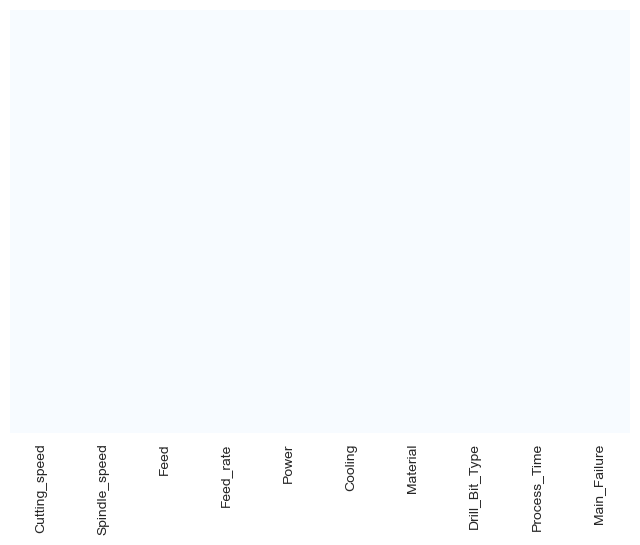

In [11]:
visual_plot. missing_value()

### STATISTICS

In [12]:
# data segmentation
fail_df = Pm_df[Pm_df['Main_Failure'] == 1]
run_df = Pm_df[Pm_df['Main_Failure'] == 0]

In [13]:
# checking for statistics of Main failure group
print('Total = ', len(Pm_df))
print('Number of failed occurence = ', len(fail_df))
print('% of failed occurence =',1.*len(fail_df)/len(Pm_df)*100, '%')

print('Number of successful run = ', len(run_df))
print('% of successful run =', 1.*len(run_df)/len(Pm_df)*100, '%')

Total =  20000
Number of failed occurence =  1001
% of failed occurence = 5.005 %
Number of successful run =  18999
% of successful run = 94.99499999999999 %


In [14]:
fail_df.describe().T

count        mean         std      min     25%      50%  \
Cutting_speed  1001.0   23.469091    5.143647   16.330   17.51   22.400   
Spindle_speed  1001.0  622.533467  136.445121  433.000  464.00  594.000   
Feed           1001.0    0.206116    0.039821    0.108    0.17    0.219   
Feed_rate      1001.0  151.687313   52.512676   62.000  112.00  133.000   
Power          1001.0  120.748941   63.041334   49.040   68.69   84.710   
Cooling        1001.0   43.831169   30.290798    0.000   25.00   50.000   
Process_Time   1001.0   28.879401    7.039086   16.670   20.22   32.900   
Main_Failure   1001.0    1.000000    0.000000    1.000    1.00    1.000   

                   75%      max  
Cutting_speed   29.580   30.670  
Spindle_speed  785.000  813.000  
Feed             0.233    0.297  
Feed_rate      211.000  250.000  
Power          191.800  269.060  
Cooling         75.000  100.000  
Process_Time    34.580   38.570  
Main_Failure     1.000    1.000

In [15]:
run_df.describe().T

count        mean         std      min      25%      50%  \
Cutting_speed  18999.0   23.314744    5.175801   16.700   17.590   22.610   
Spindle_speed  18999.0  618.439497  137.291425  443.000  467.000  600.000   
Feed           18999.0    0.225817    0.037181    0.122    0.194    0.235   
Feed_rate      18999.0  140.047266   40.724471   71.000  109.000  121.000   
Power          18999.0  129.427124   65.498153   51.990   78.920   93.560   
Cooling        18999.0   57.430654   23.363764    0.000   50.000   50.000   
Process_Time   18999.0   29.261298    6.856990   15.970   20.370   32.960   
Main_Failure   18999.0    0.000000    0.000000    0.000    0.000    0.000   

                   75%      max  
Cutting_speed   29.810   31.070  
Spindle_speed  791.000  824.000  
Feed             0.254    0.321  
Feed_rate      183.000  261.000  
Power          205.065  305.220  
Cooling         75.000  100.000  
Process_Time    34.530   38.400  
Main_Failure     0.000    0.000

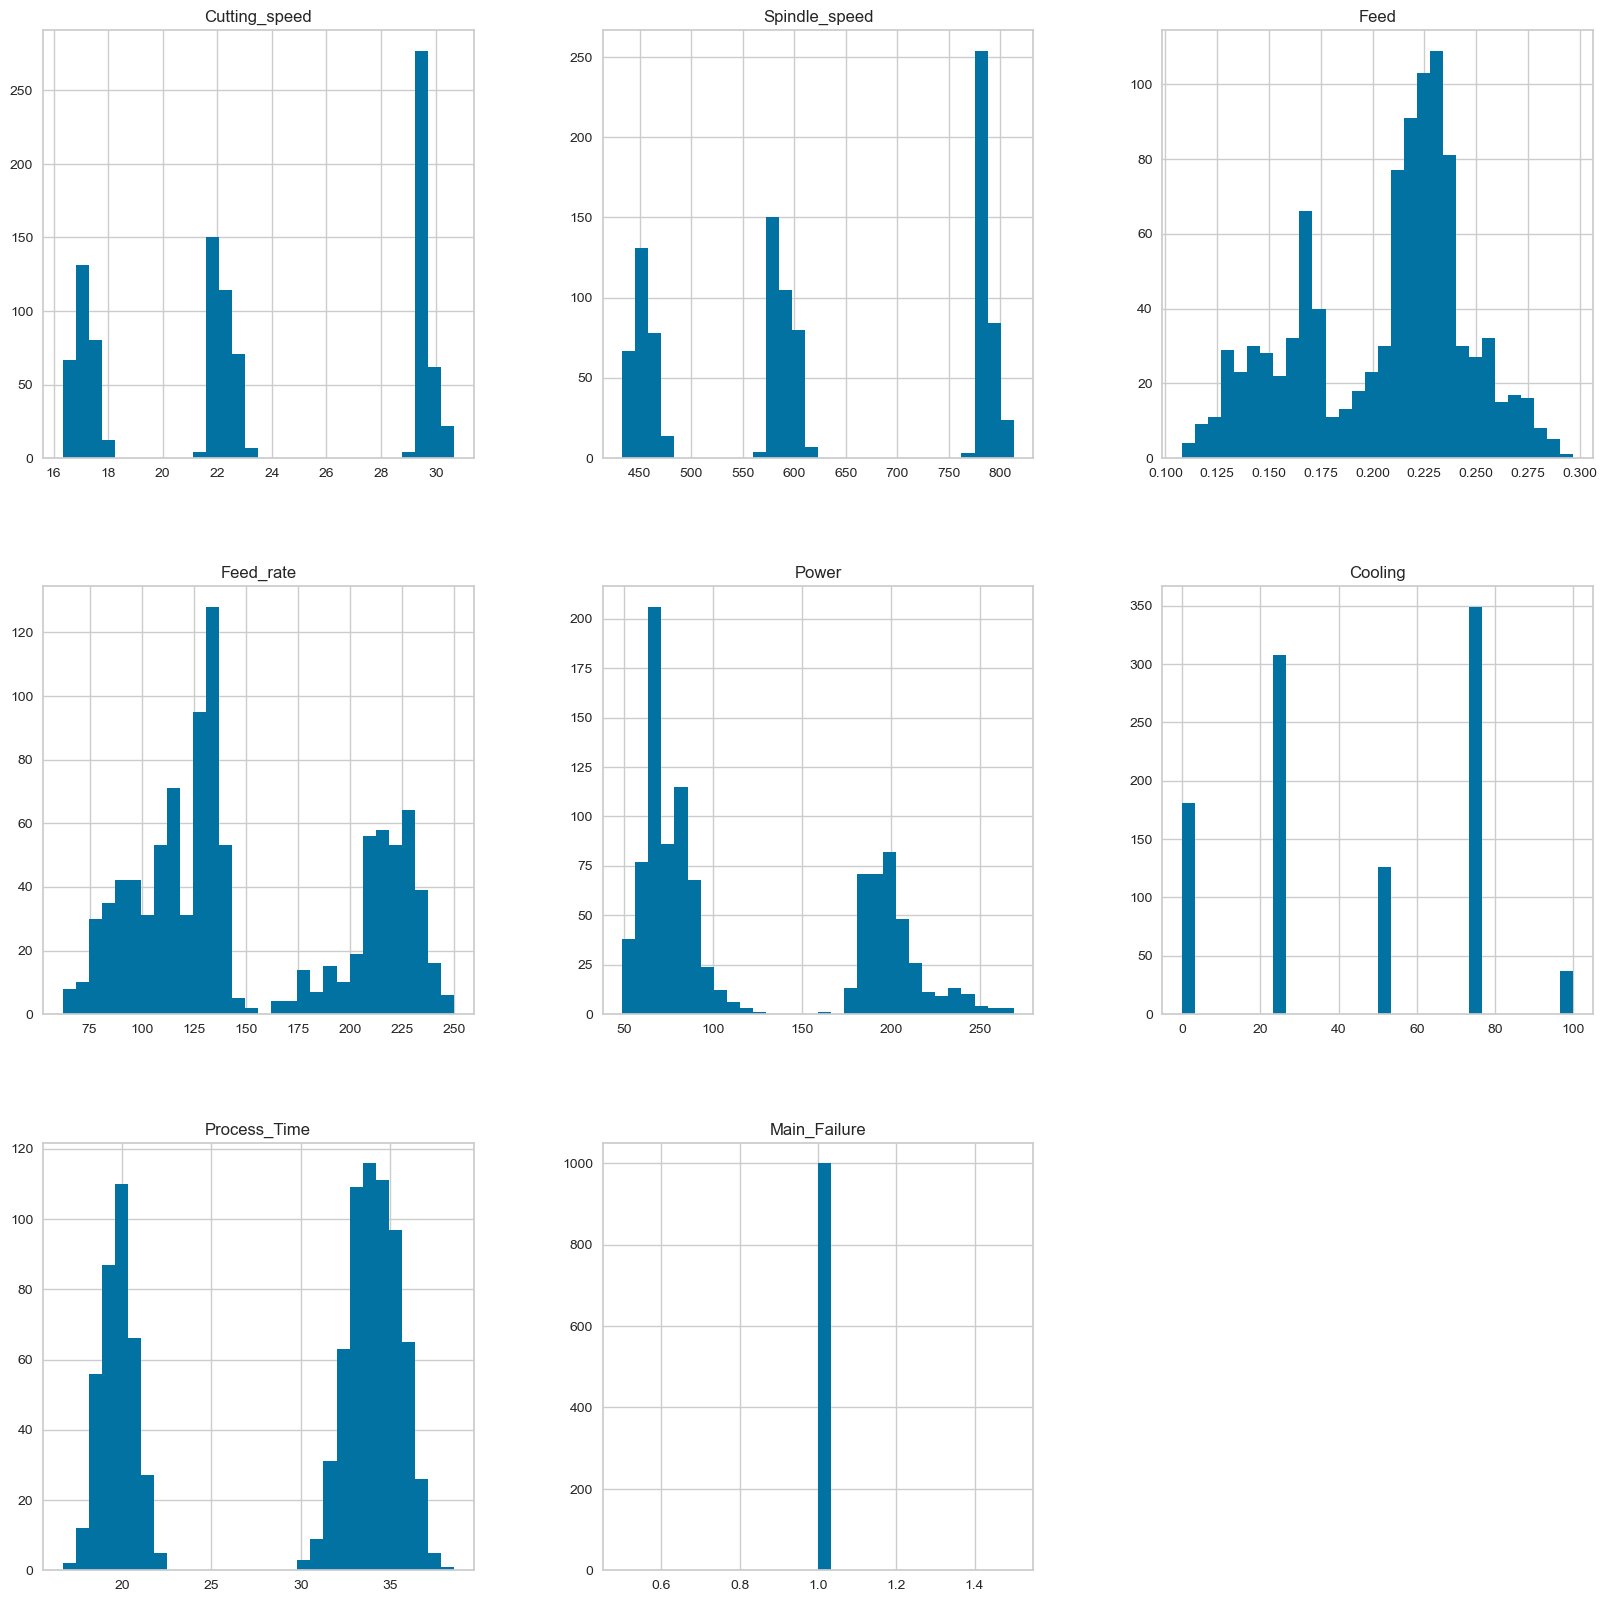

In [16]:
# checking the distribution of variable when the machine failed
fail_df.hist(bins = 30, figsize = (20,20), color = 'b')
plt.title('Distribution of Variable when the Machine Failed')
plt.show()

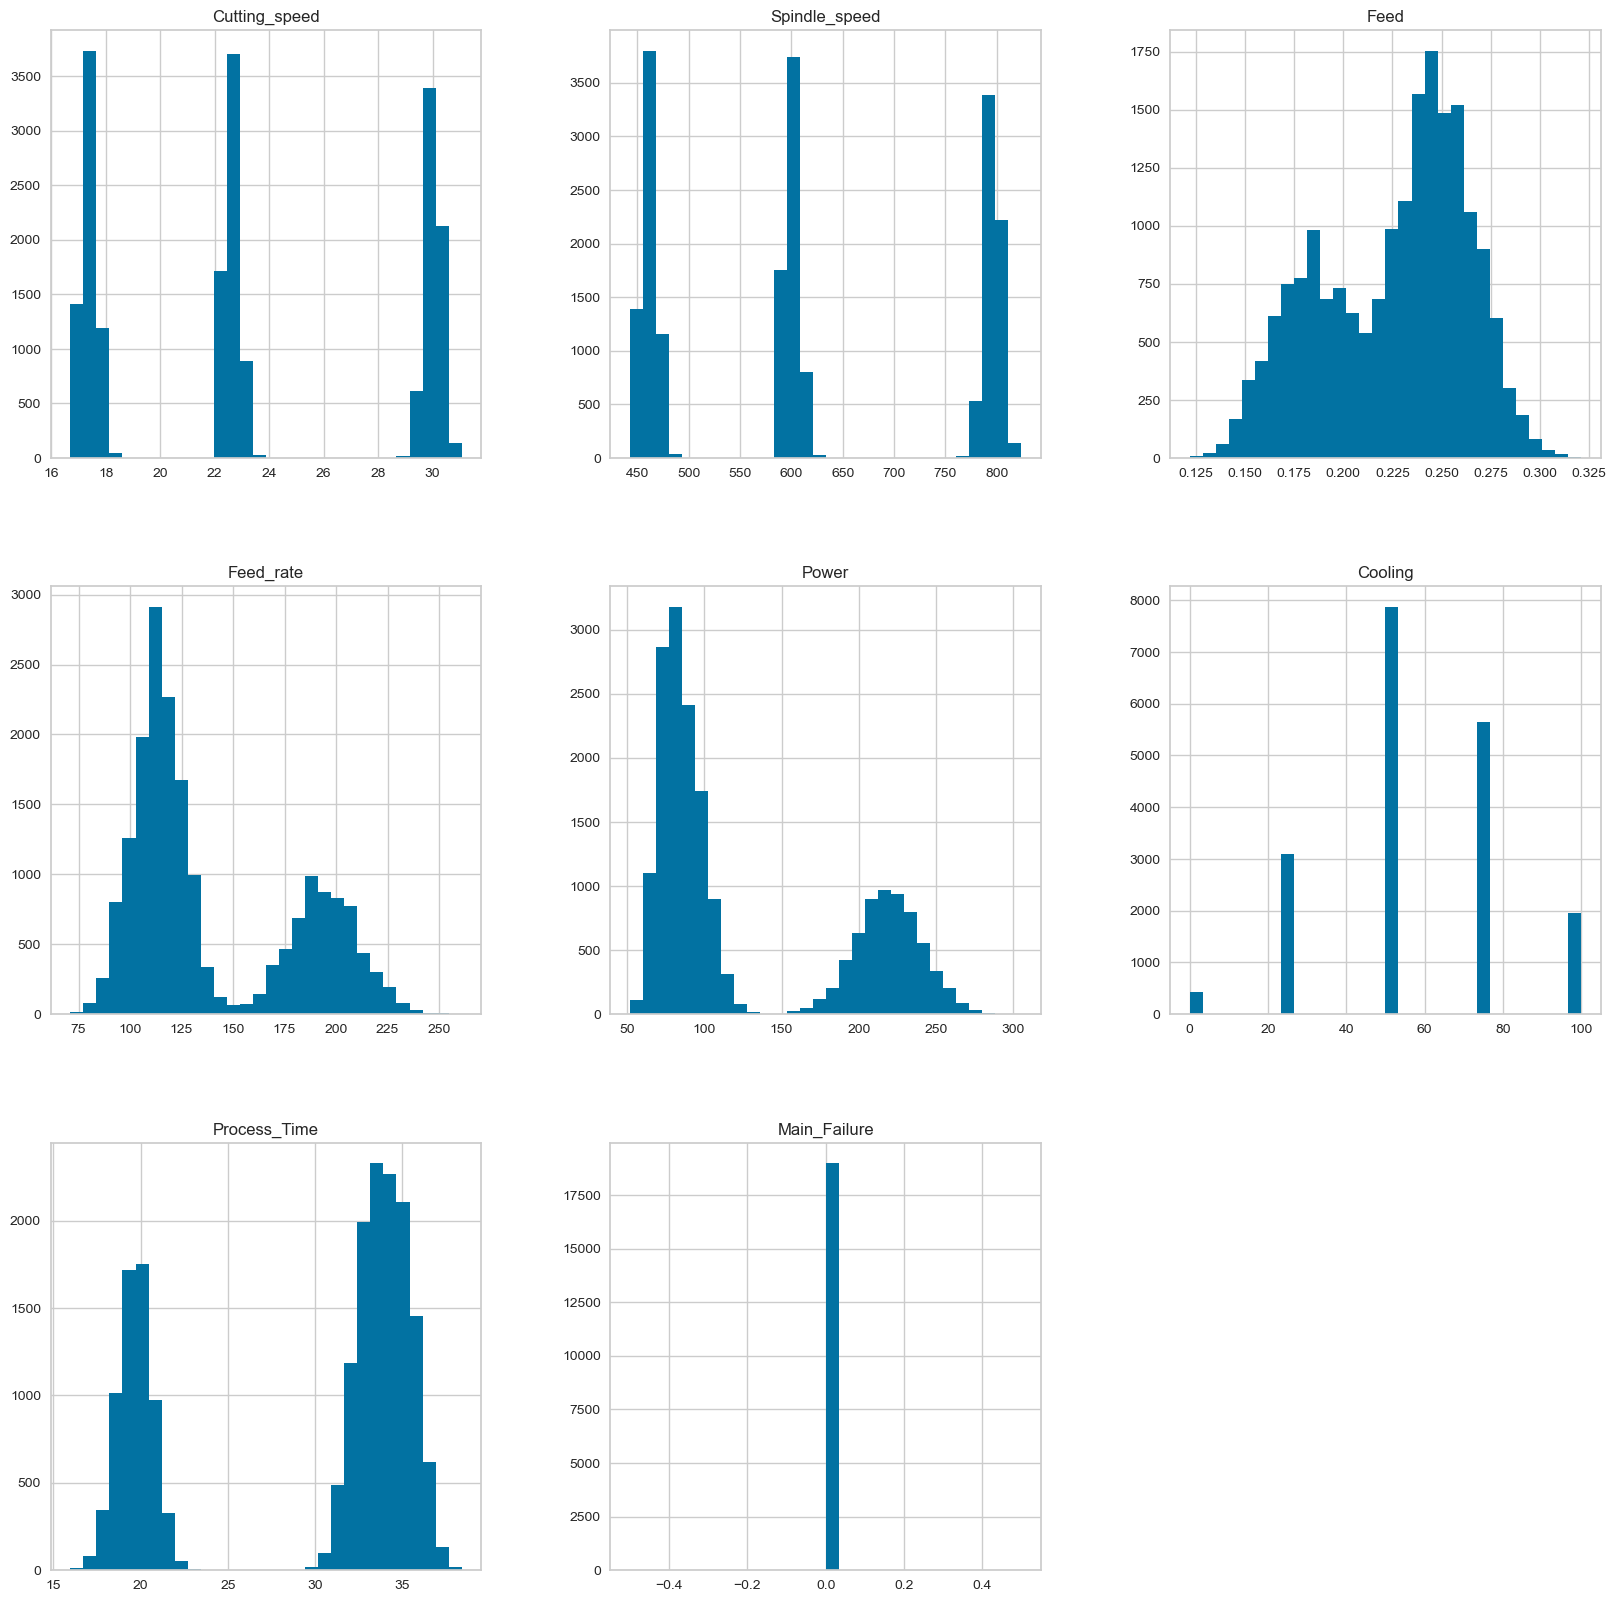

In [17]:
# checking the distribution of variable when the machine is running
run_df.hist(bins = 30, figsize = (20,20), color = 'b')
plt.title('Distribution of Variable when the Machine is Running')
plt.show()

### Kernel Density Estimate plot

In [18]:
class KDEPlotter:
    def __init__(self, fail_df, run_df):
        self.fail_df = fail_df
        self.run_df = run_df
    
    def kdeplot_feature(self, feature, xlabel=None, title=None):
        if feature not in self.fail_df.columns or feature not in self.run_df.columns:
            raise ValueError(f"Feature '{feature}' is not in the DataFrame.")
        
        plt.figure(figsize=(8, 5))
        sns.kdeplot(self.fail_df[feature], label='Machine Failed', shade=True, color='r')
        sns.kdeplot(self.run_df[feature], label='Machine Running', shade=True, color='b')
        
        plt.xlabel(xlabel if xlabel else feature)
        plt.title(title if title else f'Distribution of {feature}')
        plt.legend()
        plt.grid(False)
        plt.show()


kde_plotter = KDEPlotter(fail_df, run_df)

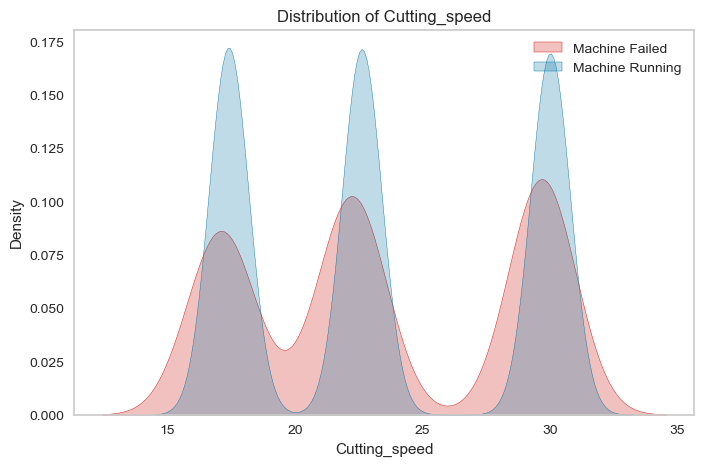

In [19]:
kde_plotter.kdeplot_feature('Cutting_speed')

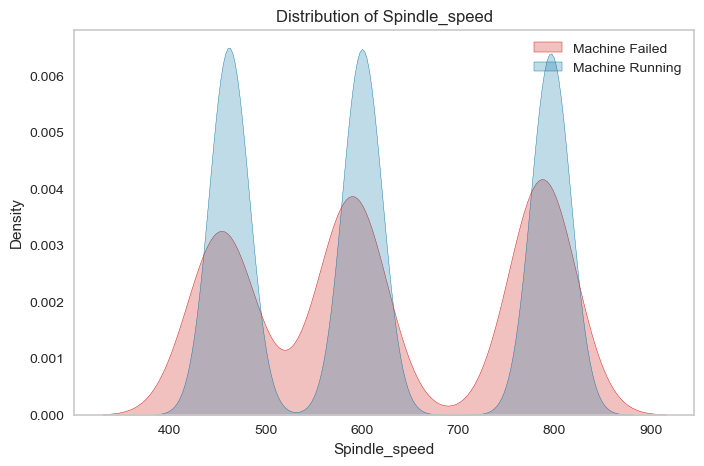

In [20]:
kde_plotter.kdeplot_feature('Spindle_speed')

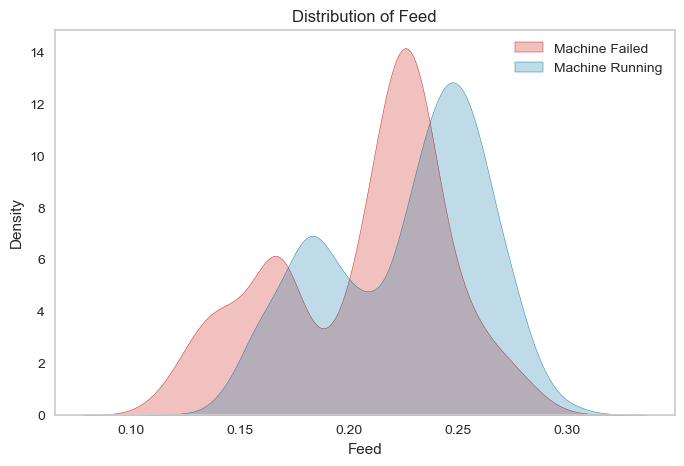

In [21]:
kde_plotter.kdeplot_feature('Feed')

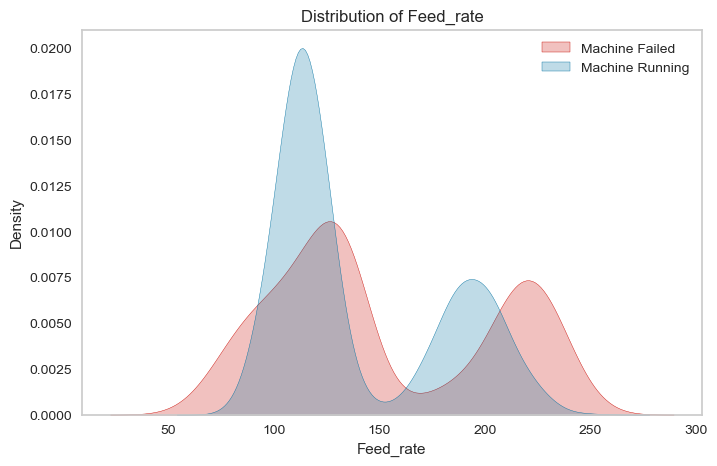

In [22]:
kde_plotter.kdeplot_feature('Feed_rate')

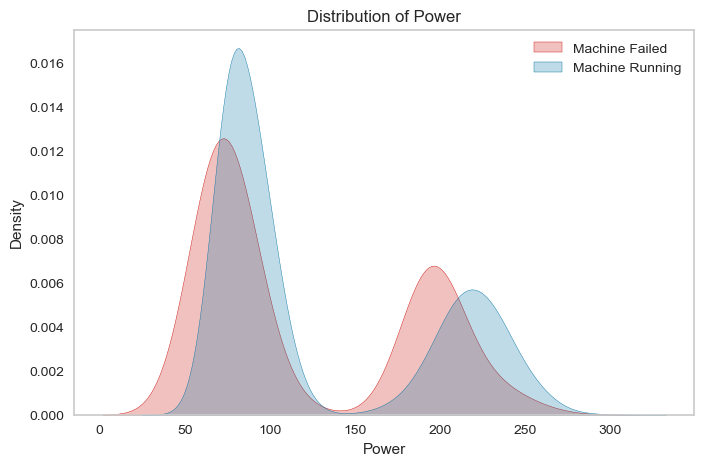

In [23]:
kde_plotter.kdeplot_feature('Power')

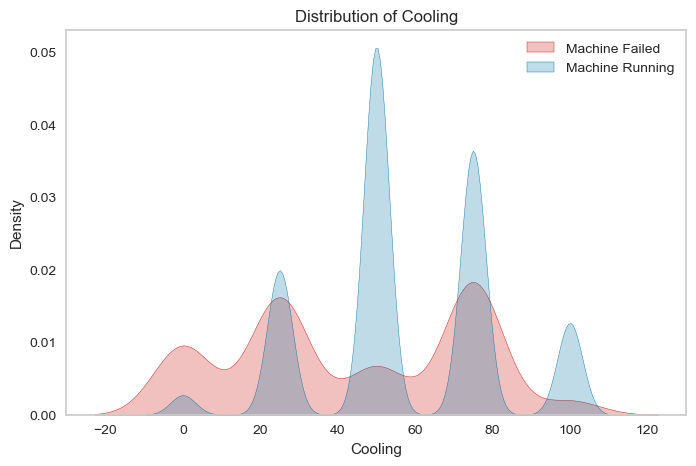

In [24]:
kde_plotter.kdeplot_feature('Cooling')

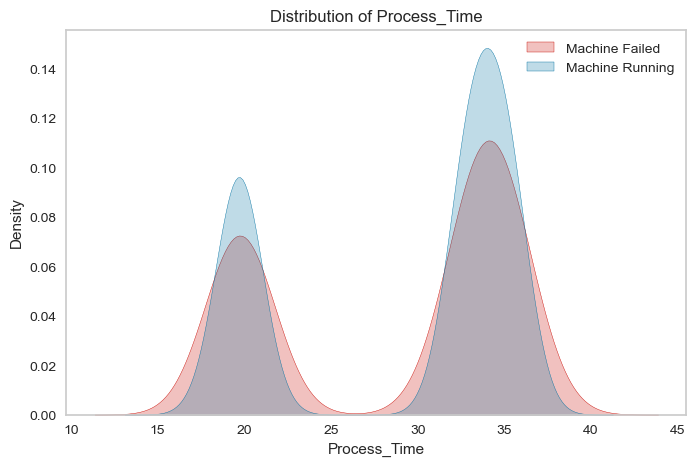

In [25]:
kde_plotter.kdeplot_feature('Process_Time')

## One-Hot-Encoding (Converting Categorical )

In [26]:
# Convert categorical variables to dummy/indicator variables
Pm_df = pd.get_dummies(Pm_df, columns=['Material', 'Drill_Bit_Type'], dtype=np.int64)

In [27]:
Pm_df.dtypes

Cutting_speed       float64
Spindle_speed         int64
Feed                float64
Feed_rate             int64
Power               float64
Cooling               int64
Process_Time        float64
Main_Failure          int64
Material_K            int64
Material_N            int64
Material_P            int64
Drill_Bit_Type_H      int64
Drill_Bit_Type_N      int64
Drill_Bit_Type_W      int64
dtype: object

In [28]:
Pm_df.head()

Cutting_speed  Spindle_speed   Feed  Feed_rate   Power  Cooling  \
0          29.92            794  0.218        173  194.87       75   
1          29.85            792  0.241        191  214.71       75   
2          22.85            606  0.183        111   95.68       50   
3          29.60            785  0.236        237  206.93       75   
4          17.43            462  0.246        114   74.85       50   

   Process_Time  Main_Failure  Material_K  Material_N  Material_P  \
0         19.26             0           0           1           0   
1         19.55             0           0           1           0   
2         36.16             0           0           0           1   
3         21.22             1           0           1           0   
4         33.56             0           1           0           0   

   Drill_Bit_Type_H  Drill_Bit_Type_N  Drill_Bit_Type_W  
0                 0                 0                 1  
1                 0                 0                 1  
2                 0                 1                 0  
3                 0                 0                 1  
4                 1                 0                 0

## Correlation

In [29]:
# dataset when machine failed
fail_df = Pm_df[Pm_df['Main_Failure'] == 1]

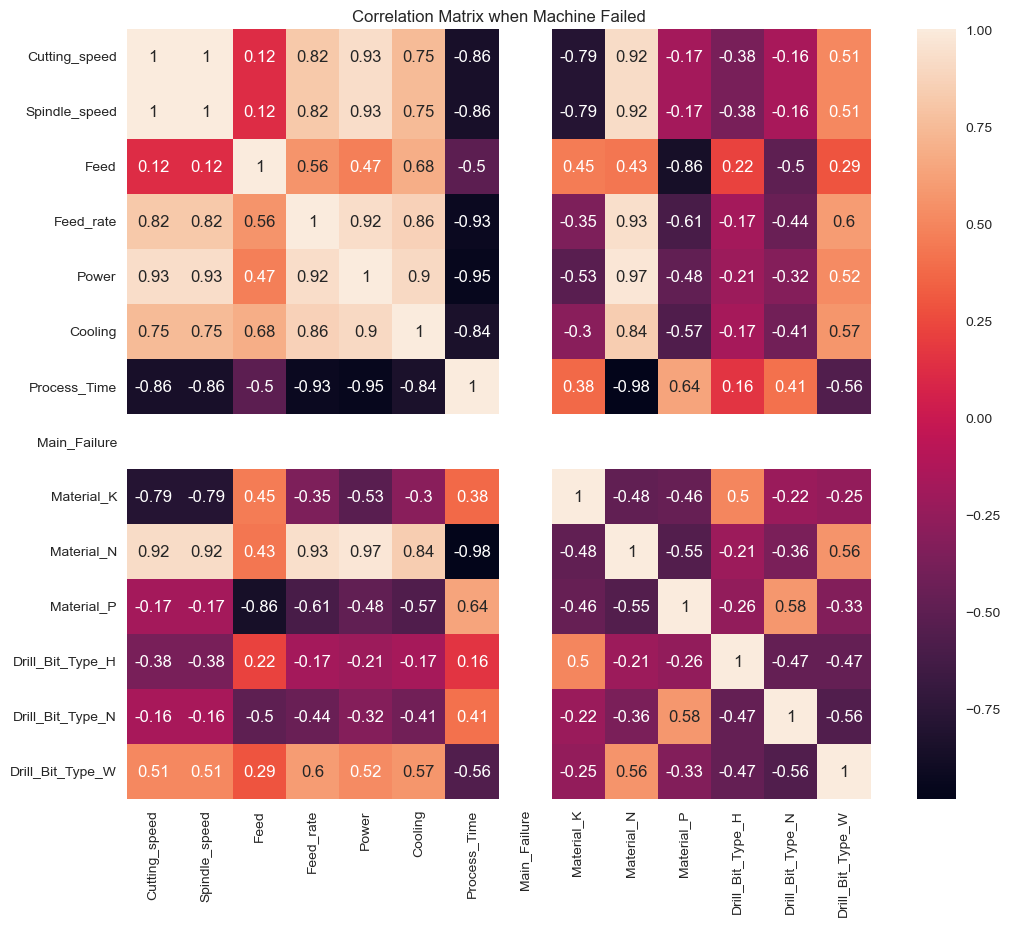

In [30]:
# Checking for correlation between variables when machine is running
def correlation_matrix():
    correlation = fail_df.corr()
    f, ax = plt.subplots(figsize = (12,10))
    sns.heatmap(correlation, annot = True)
    plt.title('Correlation Matrix when Machine Failed')
    plt.grid(False)
    plt.show()
correlation_matrix()

In [31]:
# dataset when machine is running
run_df = Pm_df[Pm_df['Main_Failure'] == 0]

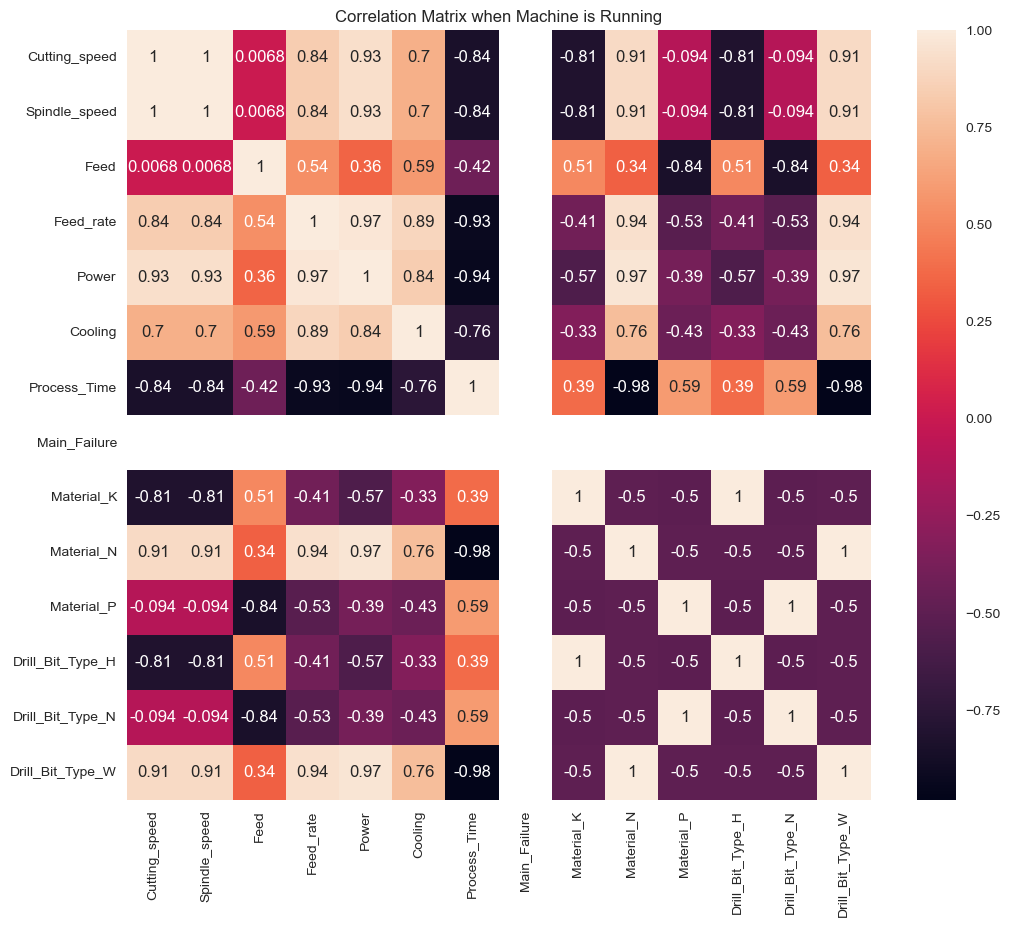

In [32]:
# Checking for correlation between variables when machine is running
def correlation_matrix():
    correlation = run_df.corr()
    f, ax = plt.subplots(figsize = (12,10))
    sns.heatmap(correlation, annot = True)
    plt.title('Correlation Matrix when Machine is Running')
    plt.grid(False)
    plt.show()
correlation_matrix()

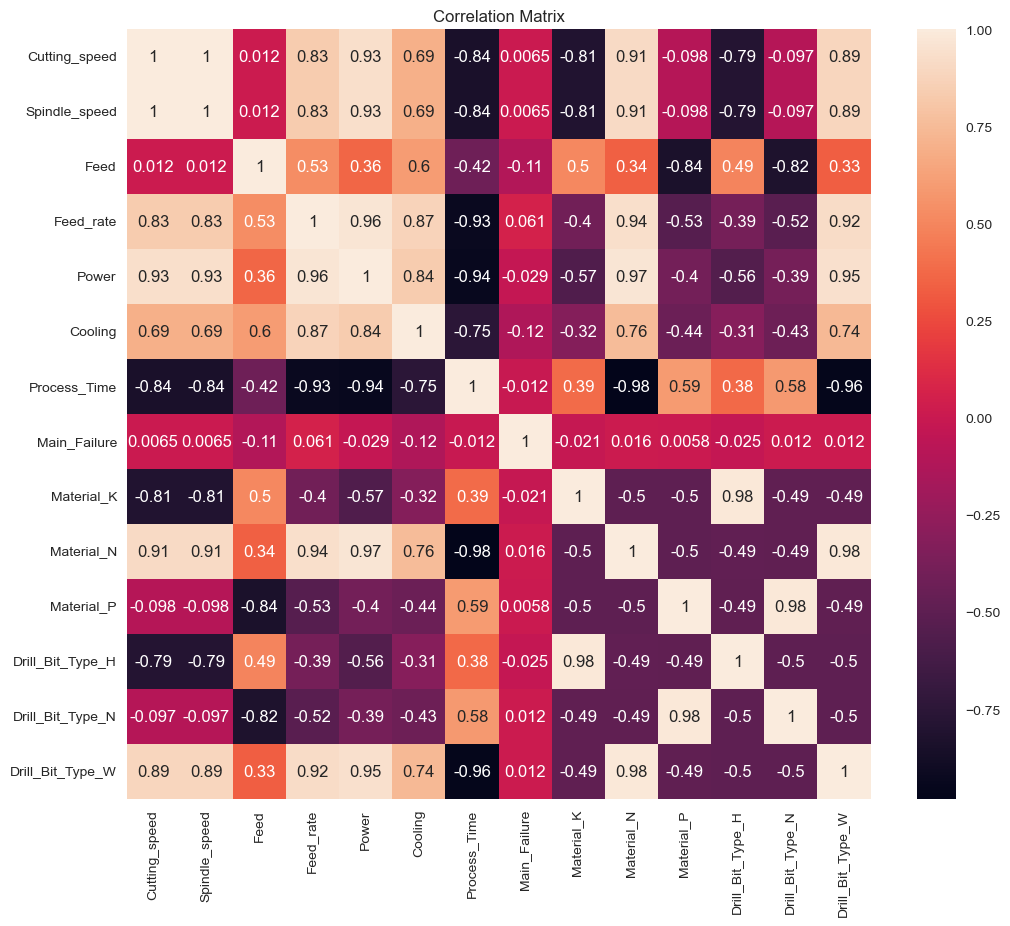

In [33]:
# Checking for correlation between variables using all dataset
def correlation_matrix():
    correlation = Pm_df.corr()
    f, ax = plt.subplots(figsize = (12,10))
    sns.heatmap(correlation, annot = True)
    plt.title('Correlation Matrix')
    plt.show()
correlation_matrix()

In [34]:
# dropping variable not needed for the analysis
Pm_df.drop(["Spindle_speed"], axis =1, inplace= True)

In [35]:
# Spindle speed is dropped because it as a one on one relationship with cutting speed which will not be good for the model

### Feature selection and target assignment

In [36]:
y = Pm_df['Main_Failure']
X = Pm_df.drop(labels=['Main_Failure'], axis=1)

In [37]:
X.head()

Cutting_speed   Feed  Feed_rate   Power  Cooling  Process_Time  Material_K  \
0          29.92  0.218        173  194.87       75         19.26           0   
1          29.85  0.241        191  214.71       75         19.55           0   
2          22.85  0.183        111   95.68       50         36.16           0   
3          29.60  0.236        237  206.93       75         21.22           0   
4          17.43  0.246        114   74.85       50         33.56           1   

   Material_N  Material_P  Drill_Bit_Type_H  Drill_Bit_Type_N  \
0           1           0                 0                 0   
1           1           0                 0                 0   
2           0           1                 0                 1   
3           1           0                 0                 0   
4           0           0                 1                 0   

   Drill_Bit_Type_W  
0                 1  
1                 1  
2                 0  
3                 1  
4                 0

In [38]:
y.unique()

array([0, 1], dtype=int64)

In [39]:
X.columns

Index(['Cutting_speed', 'Feed', 'Feed_rate', 'Power', 'Cooling',
       'Process_Time', 'Material_K', 'Material_N', 'Material_P',
       'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W'],
      dtype='object')

### Separate data into Train and Test

In [40]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 42)
X_train.shape, X_test.shape

((14000, 12), (6000, 12))

In [42]:
# Define feature names
feature_names = ['Cutting_speed', 'Spindle_speed', 'Feed', 'Feed_rate', 'Power',
                  'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                  'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W']


### Standardization

In [43]:
# Data Normalisation and Data scaling
scaler = StandardScaler()

In [44]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#### Imbalance Data Technique

In [45]:
# set up Border line SMOTE
sm_bl = BorderlineSMOTE(
    sampling_strategy='auto',  # samples only the minority class
    random_state=0,  # for reproducibility
    k_neighbors=5, # the neighbours to crete the new examples
    m_neighbors=10, # the neiighbours to find the DANGER group
    kind='borderline-1',
    n_jobs=2
)

X_resampled_b, y_resampled_b = sm_bl.fit_resample(X_train, y_train)
X_resampled_b.shape, y_resampled_b.shape

((26638, 12), (26638,))

#### Function

gini Function: To Computes the Gini coefficient for a set of predictions, which is a measure of model performance derived from the AUC.

plot_gini Function: To Plots the ROC curves for training and test sets, annotated with their respective Gini coefficients.

feat_imp Function: To Computes feature importances for an XGBoost model using multiple metrics and returns the most important features.

In [46]:
def gini(y_true, y_pred, sample = None):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    if sample:
        print(f'Gini on {sample} = {100*(2*auc(fpr,tpr)-1):.1f}')
    return 100*(2*auc(fpr,tpr)-1), fpr, tpr

def plot_gini(y_true_train, y_pred_train, y_true_test, y_pred_test):
    fig= plt.figure(figsize=(7,5))
    ax = fig.add_subplot(1,1,1)

    train_gini, fpr_train, tpr_train = gini(y_true_train, y_pred_train)
    test_gini, fpr_test, tpr_test = gini(y_true_test, y_pred_test)
    
    ax.plot(fpr_test, tpr_test, color='green', label='Test (GINI = %0.1f)' % (test_gini))
    ax.plot(fpr_train, tpr_train, color='red', label='Train (GINI = %0.1f)' % (train_gini))
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve', fontsize=16)
    ax.legend(loc="lower right", frameon=False)
    plt.show()  
    
def feat_imp(model, n = None):
    imp_type = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
    df_imp = pd.DataFrame(columns=['type', 'feature', 'importance'])

    for importance in imp_type:
        FI = pd.DataFrame.from_dict(model.get_booster().get_score(importance_type=importance), orient = 'index', columns=['importance']).reset_index().sort_values('importance', ascending = False)
        FI.columns = ['feature', 'importance']
        FI['importance'] = FI['importance']/sum(FI['importance'])
        FI.insert(0,'type',importance)
        df_imp = df_imp.append(FI)
    df_imp = df_imp.pivot(index='feature',columns='type', values='importance')
    df_imp['avg'] = df_imp[imp_type].mean(axis=1)
    if n:
        return df_imp.sort_values('avg', ascending=False).head(n)
    else:
        return df_imp.sort_values('avg', ascending=False)

#### Set up XGBOOST Model

### Original dataset

[0]	validation_0-auc:0.74449
[25]	validation_0-auc:0.99492
[50]	validation_0-auc:0.99502
[75]	validation_0-auc:0.99499
[99]	validation_0-auc:0.99481
Gini on train = 100.0
Gini on test = 99.0


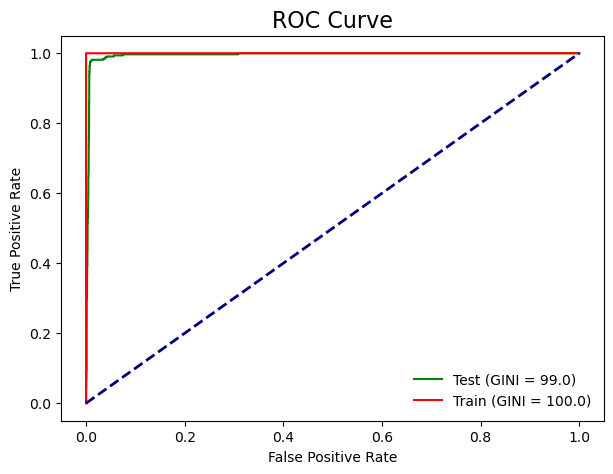

In [97]:
model = XGBClassifier(use_label_encoder=False, eval_metric = 'auc')
model.fit(X_train, y_train, eval_set = [(X_test, y_test)], verbose=25)

train_gini, _, _ = gini(y_train, model.predict_proba(X_train)[:,1], 'train')
test_gini,_ , _ = gini(y_test, model.predict_proba(X_test)[:,1], 'test')

plot_gini(y_train, model.predict_proba(X_train)[:,1], y_test, model.predict_proba(X_test)[:,1])
plt.grid(False)

In [48]:
sns.reset_orig()

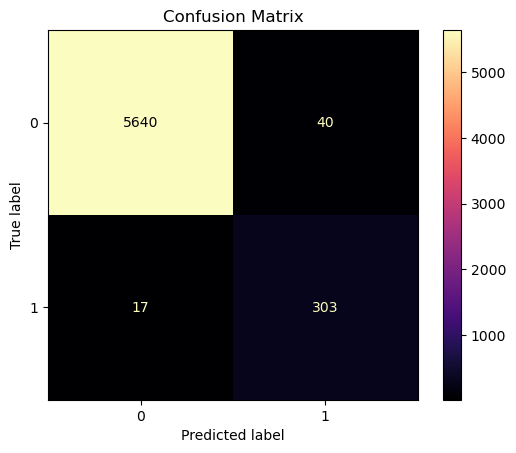

Test Classification Report:
                 precision    recall  f1-score   support

Machine Running       1.00      0.99      0.99      5680
 Machine Failed       0.88      0.95      0.91       320

       accuracy                           0.99      6000
      macro avg       0.94      0.97      0.95      6000
   weighted avg       0.99      0.99      0.99      6000



In [49]:
# Confusion matrix
pred = model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
            y_test, pred,
            labels = model.classes_,
            cmap = 'magma')

plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print('Test Classification Report:')
print(classification_report(y_test, pred, target_names=['Machine Running', 'Machine Failed']))

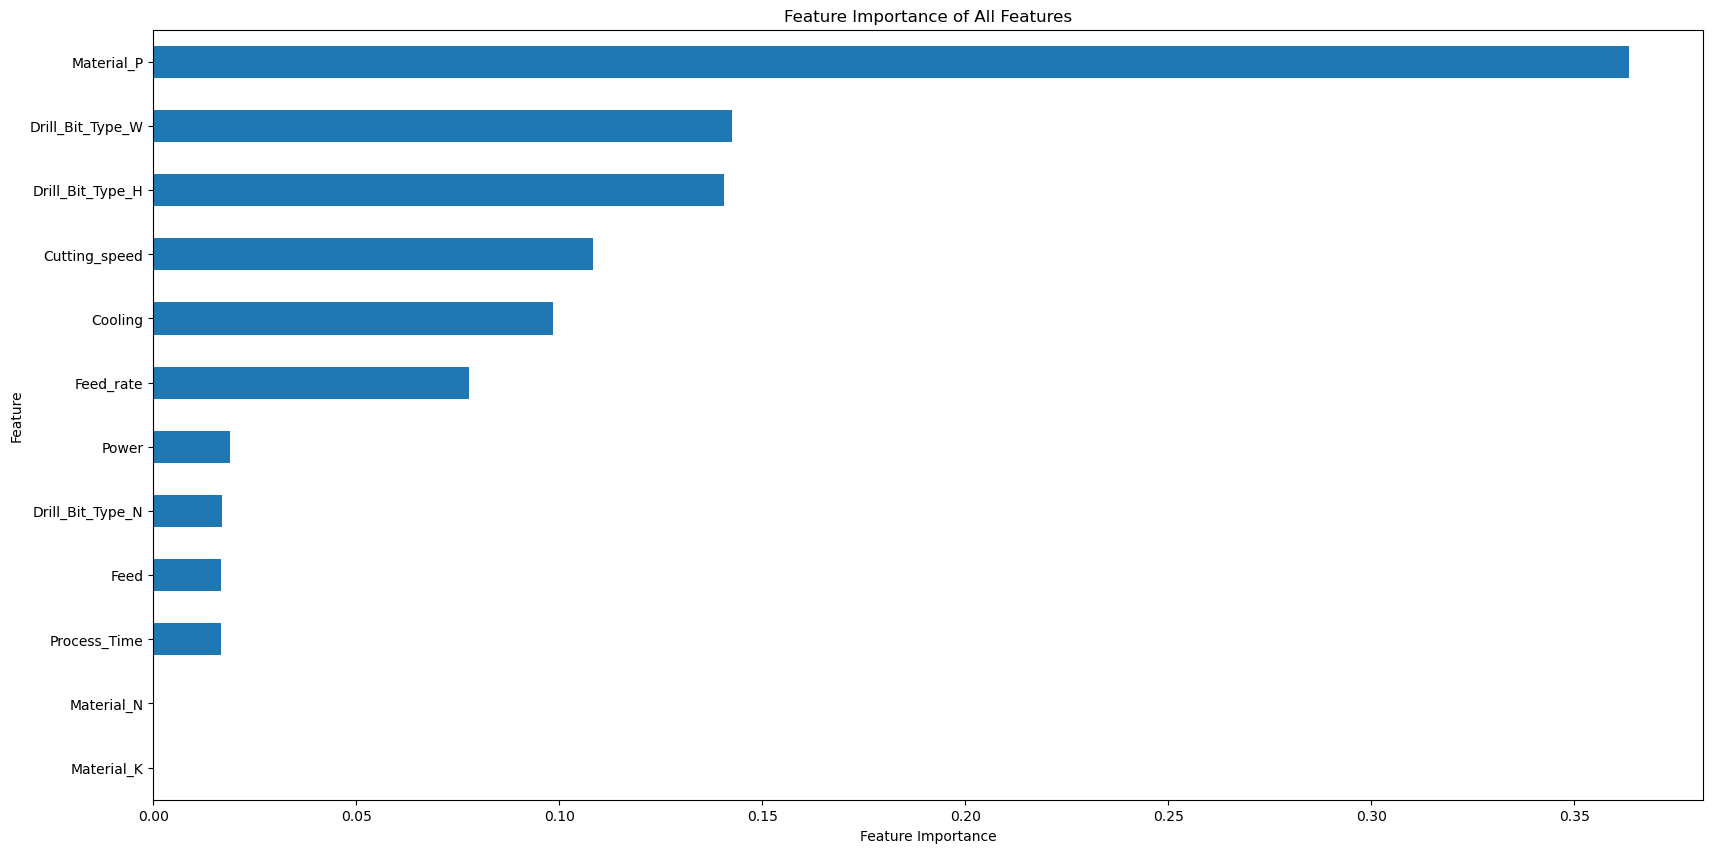

In [50]:
# Extract and sort feature importances
importances = pd.Series(model.feature_importances_, index=['Cutting_speed','Feed', 'Feed_rate', 'Power',
                                                           'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                                                           'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W'])
importances = importances.sort_values(ascending=True)

# Plot feature importances
importances.plot(kind='barh', figsize=(20, 10))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of All Features')
plt.grid(False)  # Disable grid lines
plt.show()

In [51]:
# List of feature names
feature_names = ['Cutting_speed', 'Spindle_speed', 'Feed_rate', 'Power',
                  'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                  'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W']

# Calculate permutation importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for permutation importances
perm_feat_imp = pd.DataFrame({
    'feature': feature_names,
    'mean': perm_importance.importances_mean,
    'std': perm_importance.importances_std
})

# Sort by mean importance
perm_feat_imp.sort_values('mean', inplace=True, ascending=False)

# Display the top features
perm_feat_imp.head(14)

feature      mean       std
9   Drill_Bit_Type_H  0.262850  0.003808
11  Drill_Bit_Type_W  0.259367  0.005528
0      Cutting_speed  0.236250  0.003798
2          Feed_rate  0.138917  0.002761
4            Cooling  0.026800  0.001666
1      Spindle_speed  0.021500  0.001049
5       Process_Time  0.018800  0.001110
3              Power  0.010950  0.001019
6         Material_K  0.000000  0.000000
7         Material_N  0.000000  0.000000
8         Material_P  0.000000  0.000000
10  Drill_Bit_Type_N  0.000000  0.000000

### Using Balanced data from Borderline SMOTE

[0]	validation_0-auc:0.88005
[25]	validation_0-auc:0.98726
[50]	validation_0-auc:0.98485
[75]	validation_0-auc:0.98789
[99]	validation_0-auc:0.98641
Gini on train = 100.0
Gini on test = 97.3


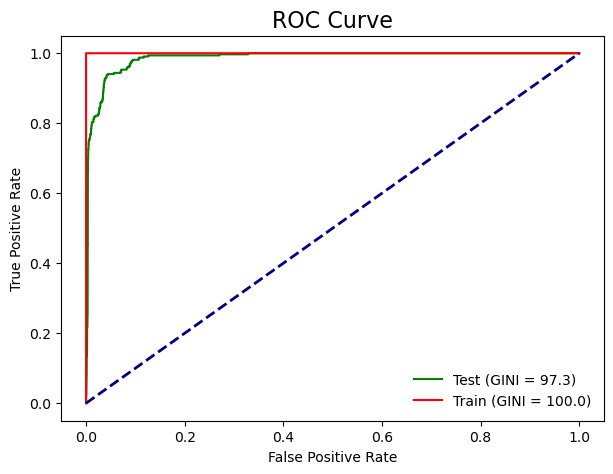

In [52]:
gmodel = XGBClassifier(use_label_encoder=False, eval_metric = 'auc')
gmodel.fit(X_resampled_b, y_resampled_b, eval_set = [(X_test, y_test)], verbose=25)

train_gini, _, _ = gini(y_resampled_b, gmodel.predict_proba(X_resampled_b)[:,1], 'train')
test_gini,_ , _ = gini(y_test, gmodel.predict_proba(X_test)[:,1], 'test')

plot_gini(y_resampled_b, gmodel.predict_proba(X_resampled_b)[:,1], y_test, gmodel.predict_proba(X_test)[:,1])

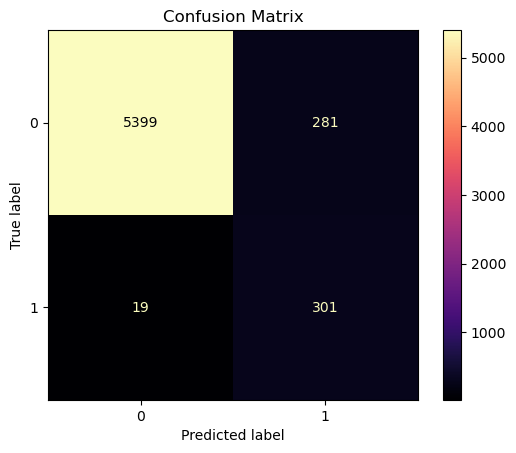

Test Classification Report:
                 precision    recall  f1-score   support

Machine Running       1.00      0.95      0.97      5680
 Machine Failed       0.52      0.94      0.67       320

       accuracy                           0.95      6000
      macro avg       0.76      0.95      0.82      6000
   weighted avg       0.97      0.95      0.96      6000



In [53]:
# Confusion matrix
pred = gmodel.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
            y_test, pred,
            labels = gmodel.classes_,
            cmap = 'magma')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print('Test Classification Report:')
print(classification_report(y_test, pred, target_names=['Machine Running', 'Machine Failed']))

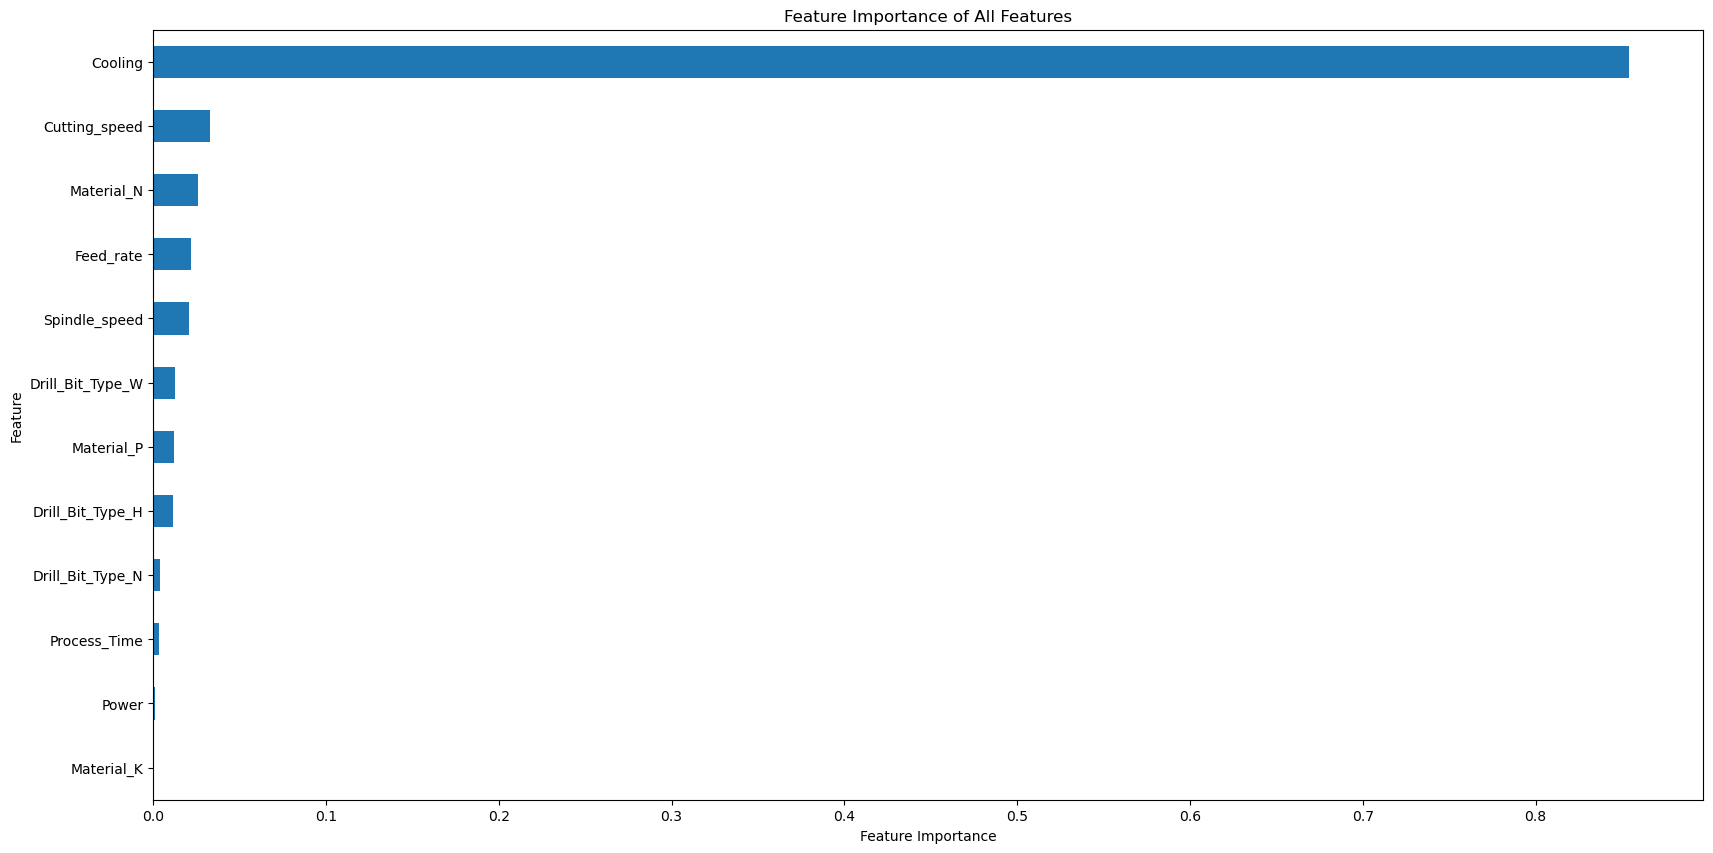

In [54]:
# Extract and sort feature importances
importances = pd.Series(gmodel.feature_importances_, index=['Cutting_speed', 'Spindle_speed', 'Feed_rate', 'Power',
                                                           'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                                                           'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W'])
importances = importances.sort_values(ascending=True)

# Plot feature importances
importances.plot(kind='barh', figsize=(20, 10))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of All Features')
plt.grid(False)  # Disable grid lines
plt.show()

In [55]:
# List of feature names
feature_names = ['Cutting_speed', 'Feed', 'Feed_rate', 'Power',
                  'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                  'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W']

# Calculate permutation importance
perm_importance = permutation_importance(gmodel, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for permutation importances
perm_feat_imp = pd.DataFrame({
    'feature': feature_names,
    'mean': perm_importance.importances_mean,
    'std': perm_importance.importances_std
})

# Sort by mean importance
perm_feat_imp.sort_values('mean', inplace=True, ascending=False)

# Display the top features
perm_feat_imp.head(14)

feature      mean       std
11  Drill_Bit_Type_W  0.281833  0.005552
0      Cutting_speed  0.155800  0.002088
9   Drill_Bit_Type_H  0.109783  0.002462
2          Feed_rate  0.106633  0.002579
5       Process_Time  0.027283  0.001747
4            Cooling  0.022400  0.001551
7         Material_N  0.019150  0.001492
3              Power  0.012783  0.000995
1               Feed  0.003967  0.001297
6         Material_K  0.000000  0.000000
8         Material_P  0.000000  0.000000
10  Drill_Bit_Type_N  0.000000  0.000000

### Hyperparameter Optimization Using Optuna

### Original dataset

In [56]:
# Hyperparameter Optimization Using Optuna
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    # Define the hyperparameters to be optimized
    param = {
        'verbosity': 0,
        'objective': 'multi:softmax',
        'num_class': 3,
        'booster': 'gbtree',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'tree_method': 'hist',  # or 'gpu_hist' if using GPU
    }

    # Initialize the model with the trial's parameters
    model = XGBClassifier(**param)

    # Perform cross-validation
    accuracy = cross_val_score(model, X_train, y_train, cv=5).mean()

    # Report the accuracy to the trial
    trial.report(accuracy, step=0)

    # Check for pruning
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return accuracy



In [57]:
# Set up the search
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5))

# Optimize
study.optimize(objective, n_trials=30)


[I 2024-08-25 18:23:29,854] A new study created in memory with name: no-name-d2ccc06d-ec24-47c1-8207-07df35f98687
[I 2024-08-25 18:23:45,409] Trial 0 finished with value: 0.9968571428571428 and parameters: {'learning_rate': 0.07350419274686004, 'n_estimators': 318, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.7645041747157701, 'colsample_bytree': 0.9327390868134842}. Best is trial 0 with value: 0.9968571428571428.
[I 2024-08-25 18:24:02,049] Trial 1 finished with value: 0.9911428571428573 and parameters: {'learning_rate': 0.012092832833171885, 'n_estimators': 429, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.9694451753077015, 'colsample_bytree': 0.6921247551264442}. Best is trial 0 with value: 0.9968571428571428.
[I 2024-08-25 18:24:20,490] Trial 2 finished with value: 0.9971428571428571 and parameters: {'learning_rate': 0.12260879864316418, 'n_estimators': 416, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.9820677284903532, 'colsample_bytree': 0.7865617112793

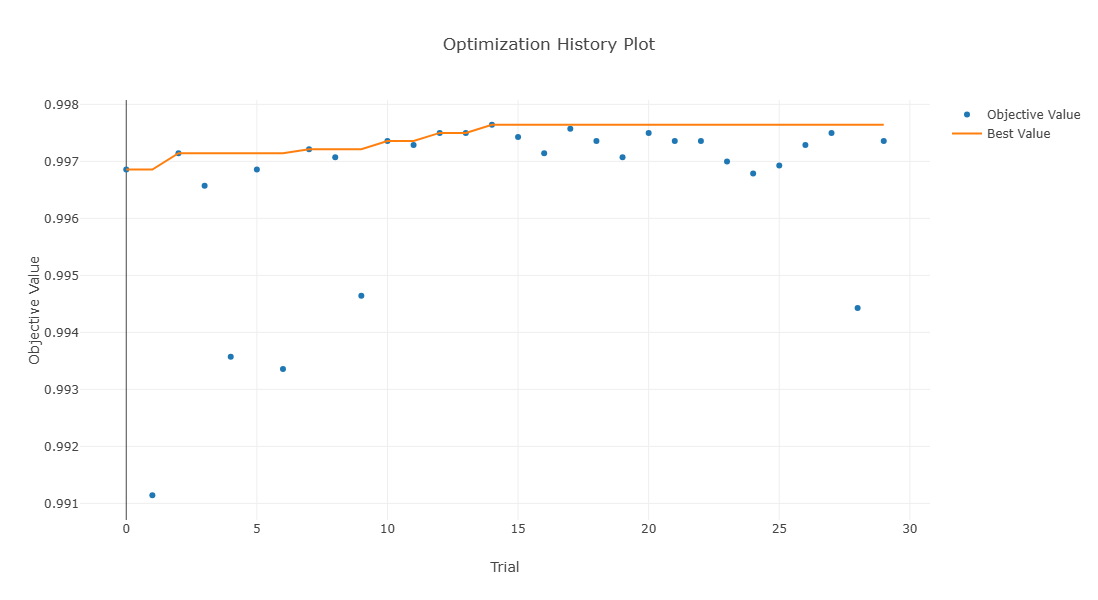

In [58]:
# Plot optimization history
opt_history = vis.plot_optimization_history(study)
opt_history.update_layout(width=1000, height=600)  # Set the size here
opt_history.show()

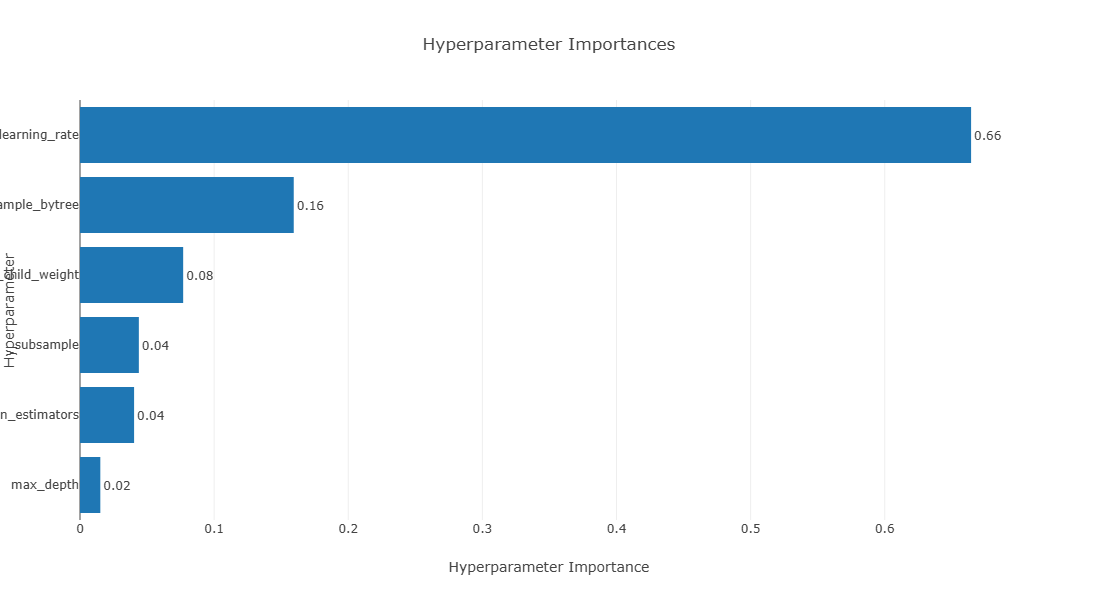

In [59]:
# Plot parameter importances
param_importances = vis.plot_param_importances(study)
param_importances.update_layout(width=1000, height=600)  # Set the size here
param_importances.show()

Gini on train = 100.0
Gini on test = 96.6


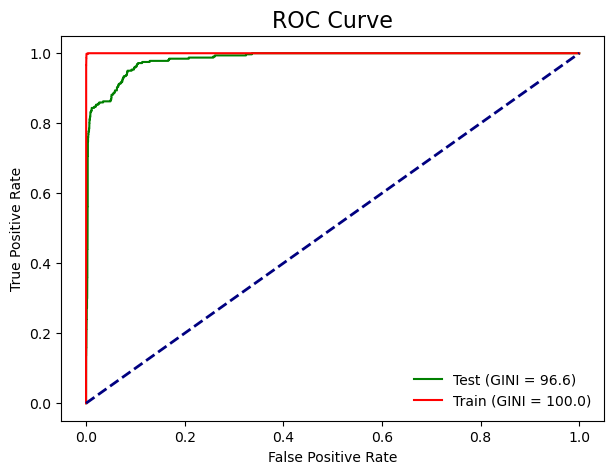

In [60]:
# The best hyperparameters
best_params = study.best_params

# Create the model using the best found parameters
best_model = XGBClassifier(**best_params)

# Train the model
best_model.fit(X_train, y_train)

# using predict_proba on the trained model
train_gini, _, _ = gini(y_train, best_model.predict_proba(X_train)[:, 1], 'train')
test_gini, _, _ = gini(y_test, best_model.predict_proba(X_test)[:, 1], 'test')

# Plotting
plot_gini(y_train, best_model.predict_proba(X_train)[:, 1], y_test, best_model.predict_proba(X_test)[:, 1])


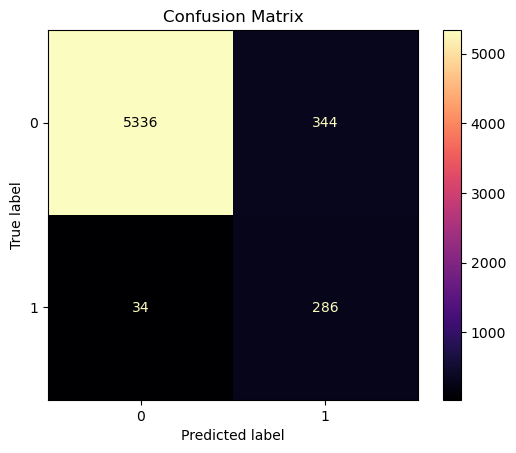

Test Classification Report:
                 precision    recall  f1-score   support

Machine Running       0.99      0.94      0.97      5680
 Machine Failed       0.45      0.89      0.60       320

       accuracy                           0.94      6000
      macro avg       0.72      0.92      0.78      6000
   weighted avg       0.96      0.94      0.95      6000



In [61]:
# Confusion matrix
pred = best_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
            y_test, pred,
            labels = best_model.classes_,
            cmap = 'magma')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print('Test Classification Report:')
print(classification_report(y_test, pred, target_names=['Machine Running', 'Machine Failed']))

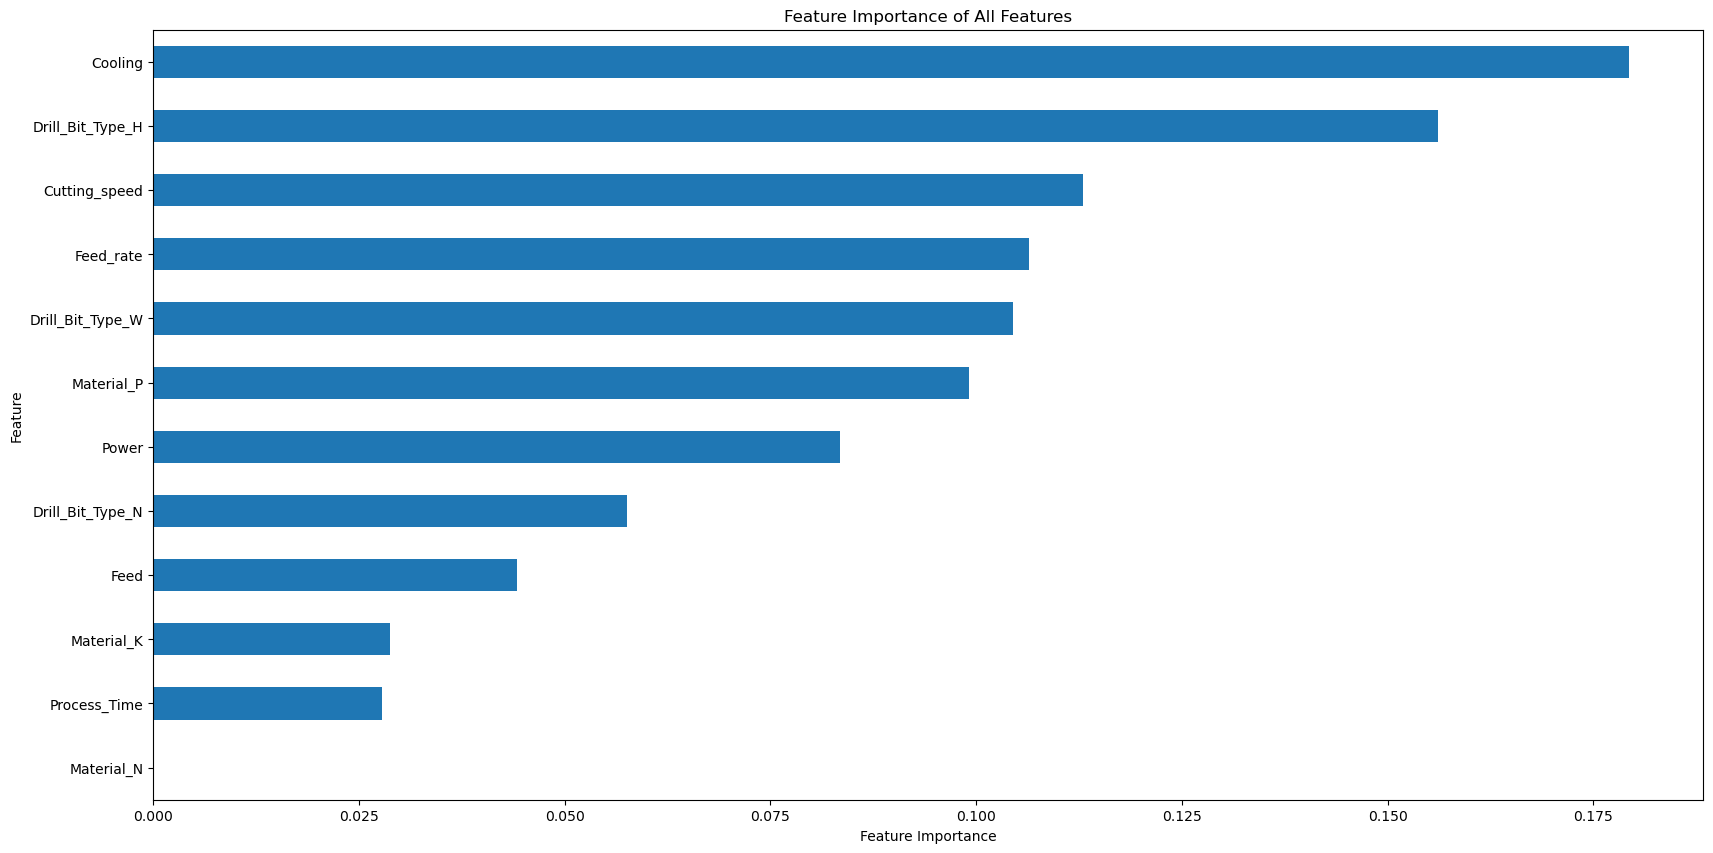

In [62]:
# Extract and sort feature importances
importances = pd.Series(best_model.feature_importances_, index=['Cutting_speed', 'Feed', 'Feed_rate', 'Power',
                                                           'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                                                           'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W'])
importances = importances.sort_values(ascending=True)

# Plot feature importances
importances.plot(kind='barh', figsize=(20, 10))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of All Features')
plt.grid(False)  # Disable grid lines
plt.show()

In [63]:
# List of feature names
feature_names = ['Cutting_speed', 'Spindle_speed', 'Feed_rate', 'Power',
                  'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                  'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W']

# Calculate permutation importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for permutation importances
perm_feat_imp = pd.DataFrame({
    'feature': feature_names,
    'mean': perm_importance.importances_mean,
    'std': perm_importance.importances_std
})

# Sort by mean importance
perm_feat_imp.sort_values('mean', inplace=True, ascending=False)

# Display the top features
perm_feat_imp.head(14)

feature      mean       std
9   Drill_Bit_Type_H  0.199817  0.003933
2          Feed_rate  0.192583  0.003646
11  Drill_Bit_Type_W  0.115800  0.002782
0      Cutting_speed  0.103100  0.003281
3              Power  0.023383  0.002648
4            Cooling  0.013050  0.002484
6         Material_K  0.008417  0.000964
7         Material_N  0.000000  0.000000
8         Material_P  0.000000  0.000000
10  Drill_Bit_Type_N  0.000000  0.000000
1      Spindle_speed -0.013850  0.001975
5       Process_Time -0.020650  0.001575

### Balanced Dataset

In [64]:
# Optuna hyperparameters

def objective(trial):
    # Define the hyperparameters to be optimized
    param = {
        'verbosity': 0,
        'objective': 'multi:softmax',
        'num_class': 3,
        'booster': 'gbtree',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'tree_method': 'hist',  # or 'gpu_hist' if using GPU
    }

    # Initialize the model with the trial's parameters
    model = XGBClassifier(**param)

    # Perform cross-validation
    accuracy = cross_val_score(model, X_resampled_b, y_resampled_b, cv=5).mean()

    # Report the accuracy to the trial
    trial.report(accuracy, step=0)

    # Check for pruning
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return accuracy



In [65]:
# Set up the search
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5))

# Optimize
study.optimize(objective, n_trials=30)


[I 2024-08-25 18:29:28,749] A new study created in memory with name: no-name-b5b224c6-93c0-4014-b35d-81428c6f3df4
[I 2024-08-25 18:30:06,811] Trial 0 finished with value: 0.9834083520351589 and parameters: {'learning_rate': 0.02210217025590199, 'n_estimators': 355, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.564445617397977, 'colsample_bytree': 0.7134497593573234}. Best is trial 0 with value: 0.9834083520351589.
[I 2024-08-25 18:30:21,685] Trial 1 finished with value: 0.9783406153478426 and parameters: {'learning_rate': 0.05479771687747002, 'n_estimators': 138, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.5297915957292201, 'colsample_bytree': 0.6894779494413366}. Best is trial 0 with value: 0.9834083520351589.
[I 2024-08-25 18:31:35,121] Trial 2 finished with value: 0.9837836358040036 and parameters: {'learning_rate': 0.015167624508077704, 'n_estimators': 425, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.6113801922153067, 'colsample_bytree': 0.96207750926260

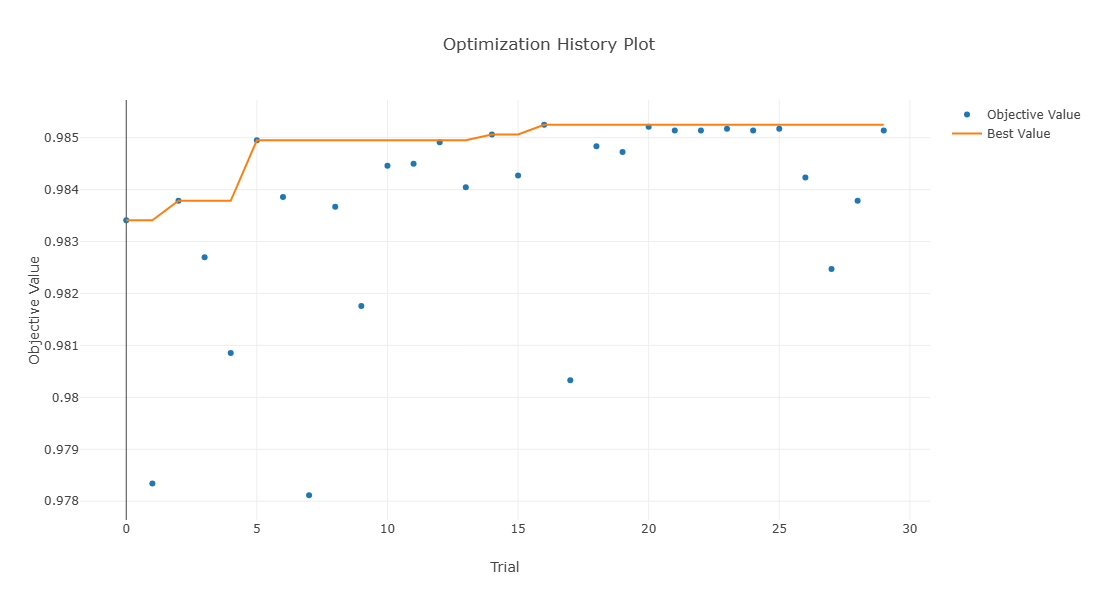

In [66]:
# Plot optimization history
opt_history = vis.plot_optimization_history(study)
opt_history.update_layout(width=1000, height=600)  # Set the size here
opt_history.show()

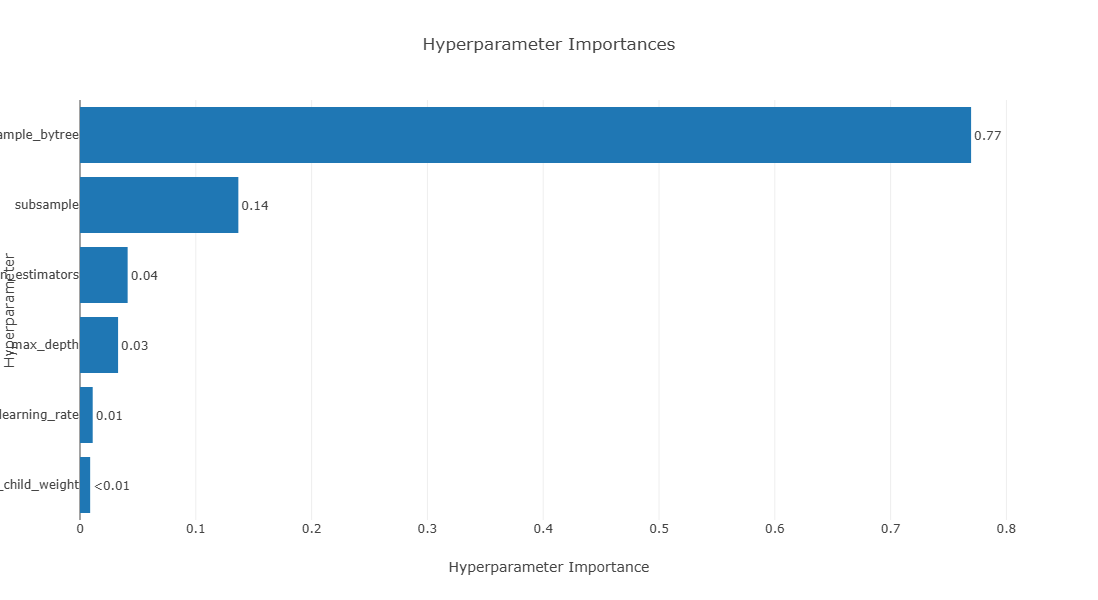

In [67]:
# Plot parameter importances
param_importances = vis.plot_param_importances(study)
param_importances.update_layout(width=1000, height=600)  # Set the size here
param_importances.show()

Gini on train = 100.0
Gini on test = 98.0


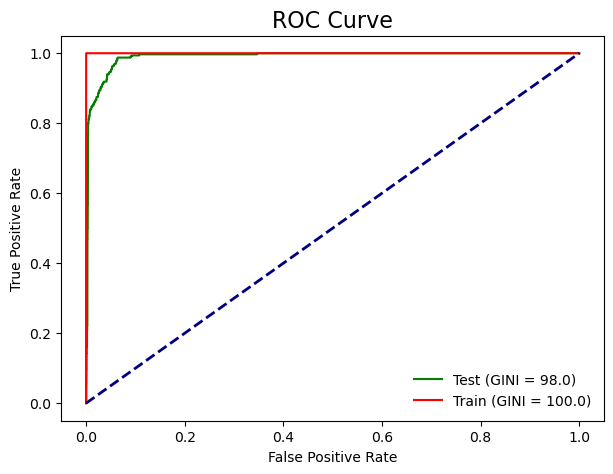

In [68]:
# Best hyperparameters
best_params = study.best_params

# best found parameters
best_model = XGBClassifier(**best_params)

# Train the model
best_model.fit(X_resampled_b, y_resampled_b)

# predict_proba on the trained model
train_gini, _, _ = gini(y_resampled_b, best_model.predict_proba(X_resampled_b)[:, 1], 'train')
test_gini, _, _ = gini(y_test, best_model.predict_proba(X_test)[:, 1], 'test')

# Plotting 
plot_gini(y_resampled_b, best_model.predict_proba(X_resampled_b)[:, 1], y_test, best_model.predict_proba(X_test)[:, 1])


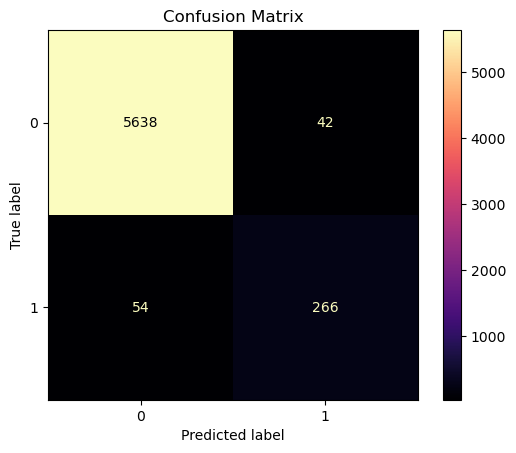

Test Classification Report:
                 precision    recall  f1-score   support

Machine Running       0.99      0.99      0.99      5680
 Machine Failed       0.86      0.83      0.85       320

       accuracy                           0.98      6000
      macro avg       0.93      0.91      0.92      6000
   weighted avg       0.98      0.98      0.98      6000



In [69]:
# Confusion Matrix
pred = best_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
            y_test, pred,
            labels = best_model.classes_,
            cmap = 'magma')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print('Test Classification Report:')
print(classification_report(y_test, pred, target_names=['Machine Running', 'Machine Failed']))

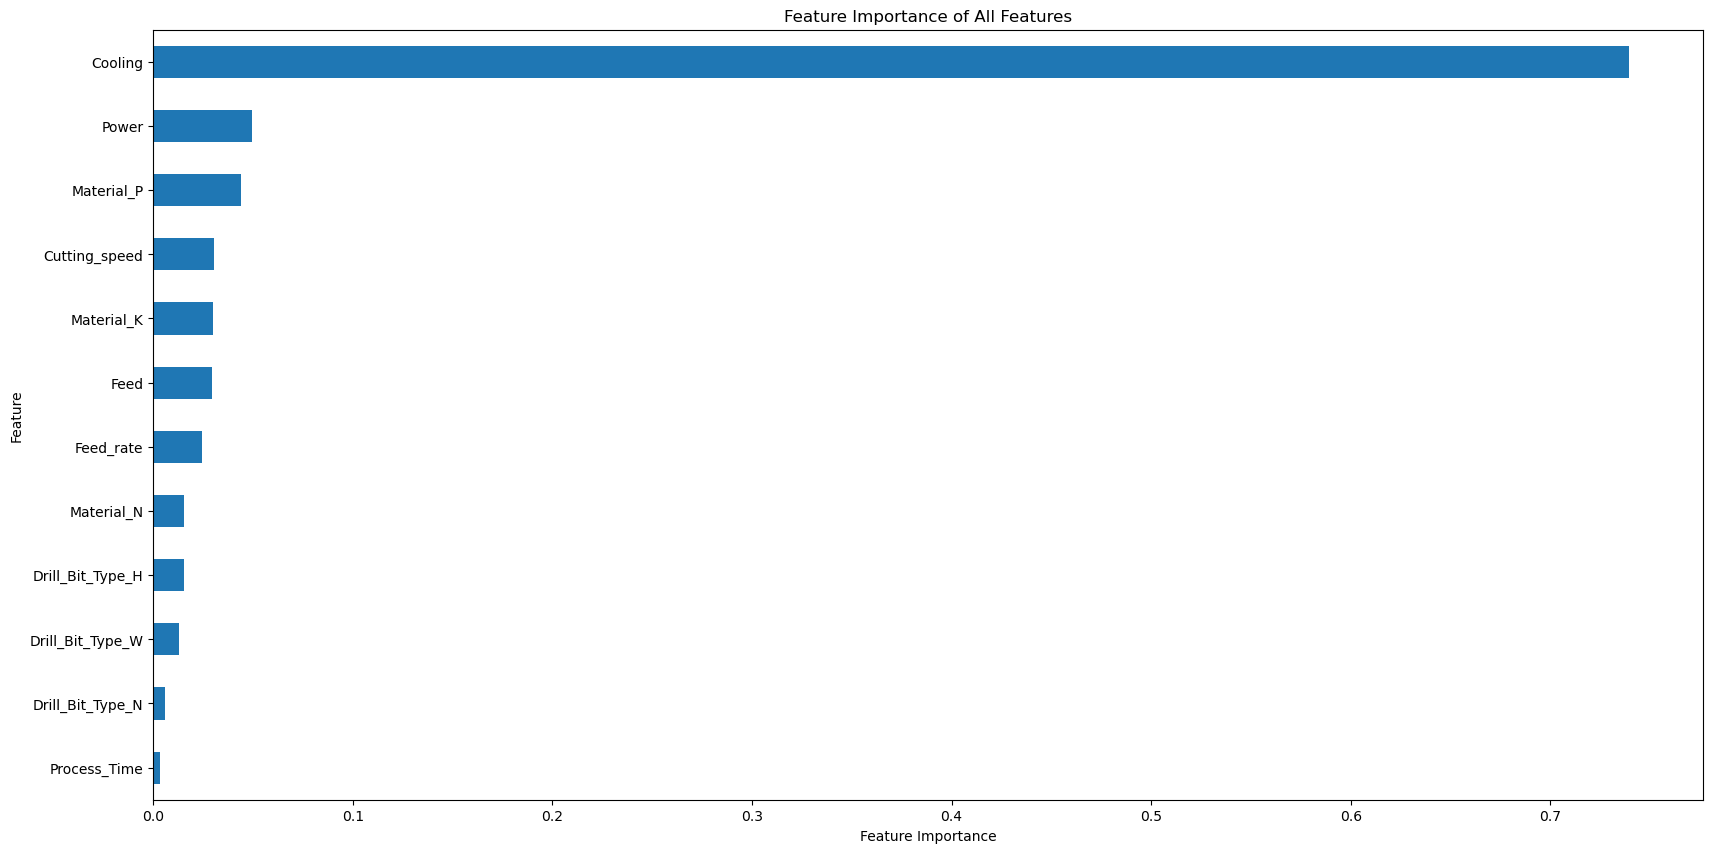

In [70]:
# Extract and sort feature importances
importances = pd.Series(best_model.feature_importances_, index=['Cutting_speed', 'Feed', 'Feed_rate', 'Power',
                                                           'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                                                           'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W'])
importances = importances.sort_values(ascending=True)

# Plot feature importances
importances.plot(kind='barh', figsize=(20, 10))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of All Features')
plt.grid(False)  # Disable grid lines
plt.show()

In [71]:
# List of feature names
feature_names = ['Cutting_speed', 'Feed', 'Feed_rate', 'Power',
                  'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                  'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W']

# Calculate permutation importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for permutation importances
perm_feat_imp = pd.DataFrame({
    'feature': feature_names,
    'mean': perm_importance.importances_mean,
    'std': perm_importance.importances_std
})

# Sort by mean importance
perm_feat_imp.sort_values('mean', inplace=True, ascending=False)

# Display the top features
perm_feat_imp.head(14)

feature      mean       std
0      Cutting_speed  0.167217  0.002452
11  Drill_Bit_Type_W  0.145450  0.004493
9   Drill_Bit_Type_H  0.139517  0.002861
2          Feed_rate  0.108817  0.001395
1               Feed  0.019967  0.001341
4            Cooling  0.004183  0.000783
5       Process_Time  0.003350  0.000825
3              Power  0.003100  0.000343
6         Material_K  0.000167  0.000129
8         Material_P  0.000000  0.000000
10  Drill_Bit_Type_N  0.000000  0.000000
7         Material_N -0.000550  0.000167

### Random Forest

### Original dataset

Gini on train = 100.0
Gini on test = 99.8


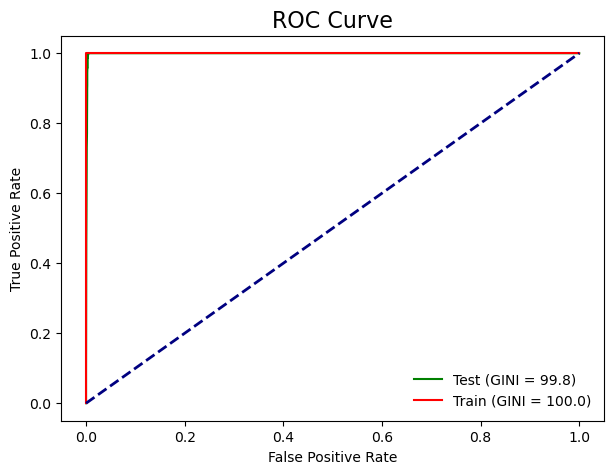

In [72]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42, n_estimators=100)  # Adjust parameters as needed
rf.fit(X_train, y_train)

# Compute the Gini coefficients
train_gini, _, _ = gini(y_train, rf.predict_proba(X_train)[:,1], 'train')
test_gini, _, _ = gini(y_test, rf.predict_proba(X_test)[:,1], 'test')

# Plot the Gini coefficients
plot_gini(y_train, rf.predict_proba(X_train)[:,1], y_test, rf.predict_proba(X_test)[:,1])

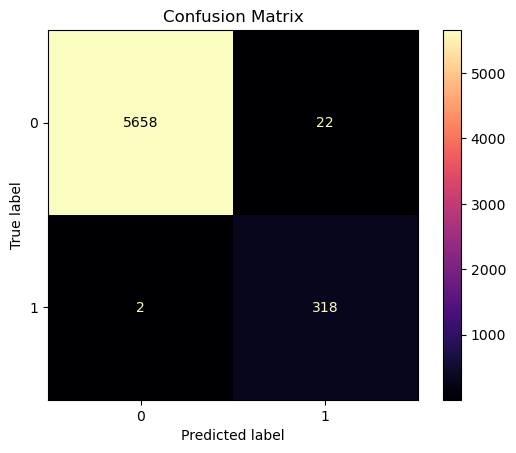

Test Classification Report:
                 precision    recall  f1-score   support

Machine Running       1.00      1.00      1.00      5680
 Machine Failed       0.94      0.99      0.96       320

       accuracy                           1.00      6000
      macro avg       0.97      0.99      0.98      6000
   weighted avg       1.00      1.00      1.00      6000



In [73]:
# Confusion matrix
pred = rf.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
            y_test, pred,
            labels = rf.classes_,
            cmap = 'magma')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print('Test Classification Report:')
print(classification_report(y_test, pred, target_names=['Machine Running', 'Machine Failed']))

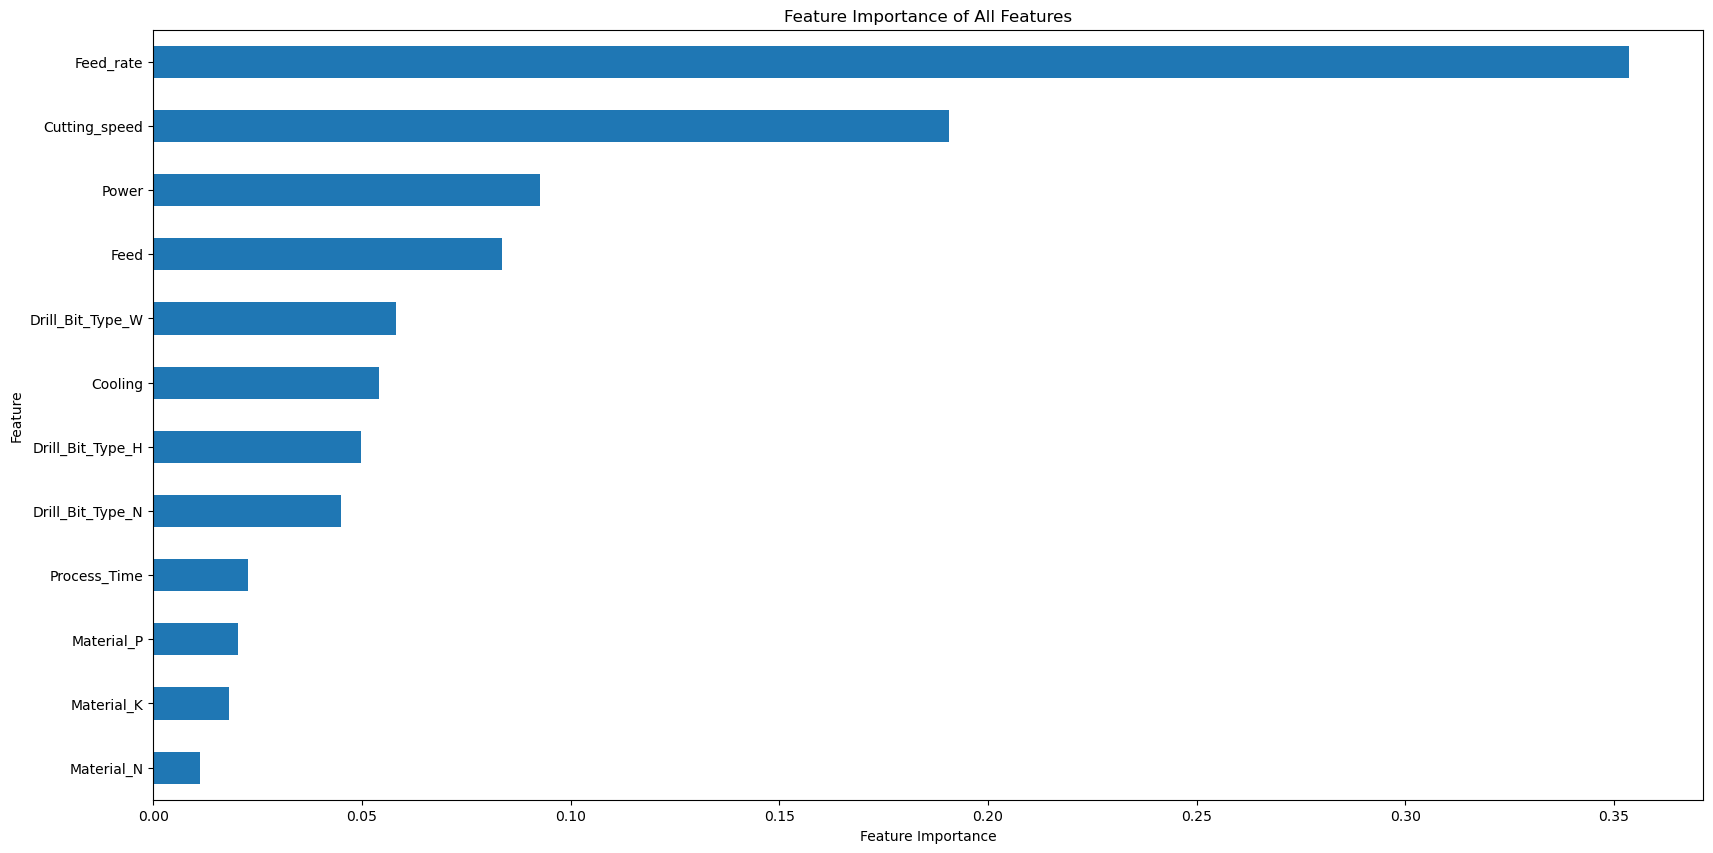

In [74]:
# Extract and sort feature importances
importances = pd.Series(rf.feature_importances_, index=['Cutting_speed', 'Feed', 'Feed_rate', 'Power',
                                                           'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                                                           'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W'])
importances = importances.sort_values(ascending=True)

# Plot feature importances
importances.plot(kind='barh', figsize=(20, 10))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of All Features')
plt.grid(False)  # Disable grid lines
plt.show()

In [75]:
# List of feature names
feature_names = ['Cutting_speed', 'Feed', 'Feed_rate', 'Power',
                  'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                  'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W']

# Calculate permutation importance
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for permutation importances
perm_feat_imp = pd.DataFrame({
    'feature': feature_names,
    'mean': perm_importance.importances_mean,
    'std': perm_importance.importances_std
})

# Sort by mean importance
perm_feat_imp.sort_values('mean', inplace=True, ascending=False)

# Display the top features
perm_feat_imp.head(14)

feature      mean       std
9   Drill_Bit_Type_H  0.348233  0.006309
11  Drill_Bit_Type_W  0.232667  0.004851
10  Drill_Bit_Type_N  0.192117  0.003502
2          Feed_rate  0.109000  0.001713
0      Cutting_speed  0.042100  0.001592
4            Cooling  0.013767  0.001160
1               Feed  0.003033  0.000795
3              Power  0.000133  0.000100
7         Material_N  0.000100  0.000082
6         Material_K  0.000067  0.000082
8         Material_P  0.000033  0.000067
5       Process_Time -0.000100  0.000170

### Balanced dataset

Gini on train = 100.0
Gini on test = 99.6


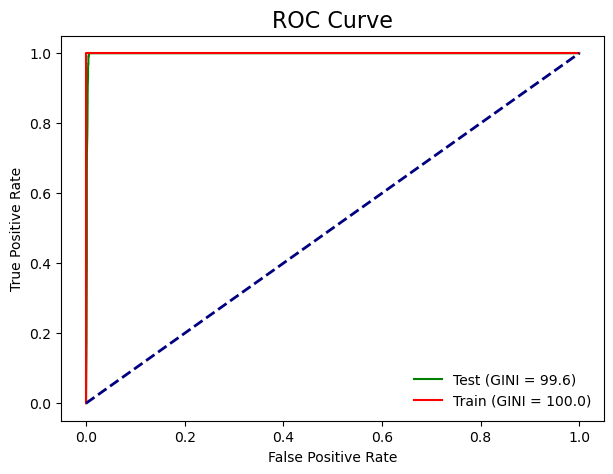

In [76]:
# Initialize the RandomForestClassifier
rfmodel = RandomForestClassifier(random_state=42, n_estimators=100)  # Adjust parameters as needed
rfmodel.fit(X_resampled_b, y_resampled_b)

# Compute the Gini coefficients
train_gini, _, _ = gini(y_resampled_b, rfmodel.predict_proba(X_resampled_b)[:,1], 'train')
test_gini, _, _ = gini(y_test, rfmodel.predict_proba(X_test)[:,1], 'test')

# Plot the Gini coefficients
plot_gini(y_resampled_b, rfmodel.predict_proba(X_resampled_b)[:,1], y_test, rfmodel.predict_proba(X_test)[:,1])

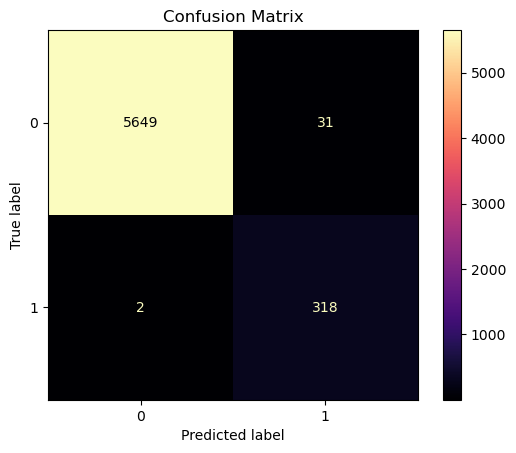

Test Classification Report:
                 precision    recall  f1-score   support

Machine Running       1.00      0.99      1.00      5680
 Machine Failed       0.91      0.99      0.95       320

       accuracy                           0.99      6000
      macro avg       0.96      0.99      0.97      6000
   weighted avg       0.99      0.99      0.99      6000



In [77]:
# Confusion matrix
pred = rfmodel.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
            y_test, pred,
            labels = rfmodel.classes_,
            cmap = 'magma')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print('Test Classification Report:')
print(classification_report(y_test, pred, target_names=['Machine Running', 'Machine Failed']))

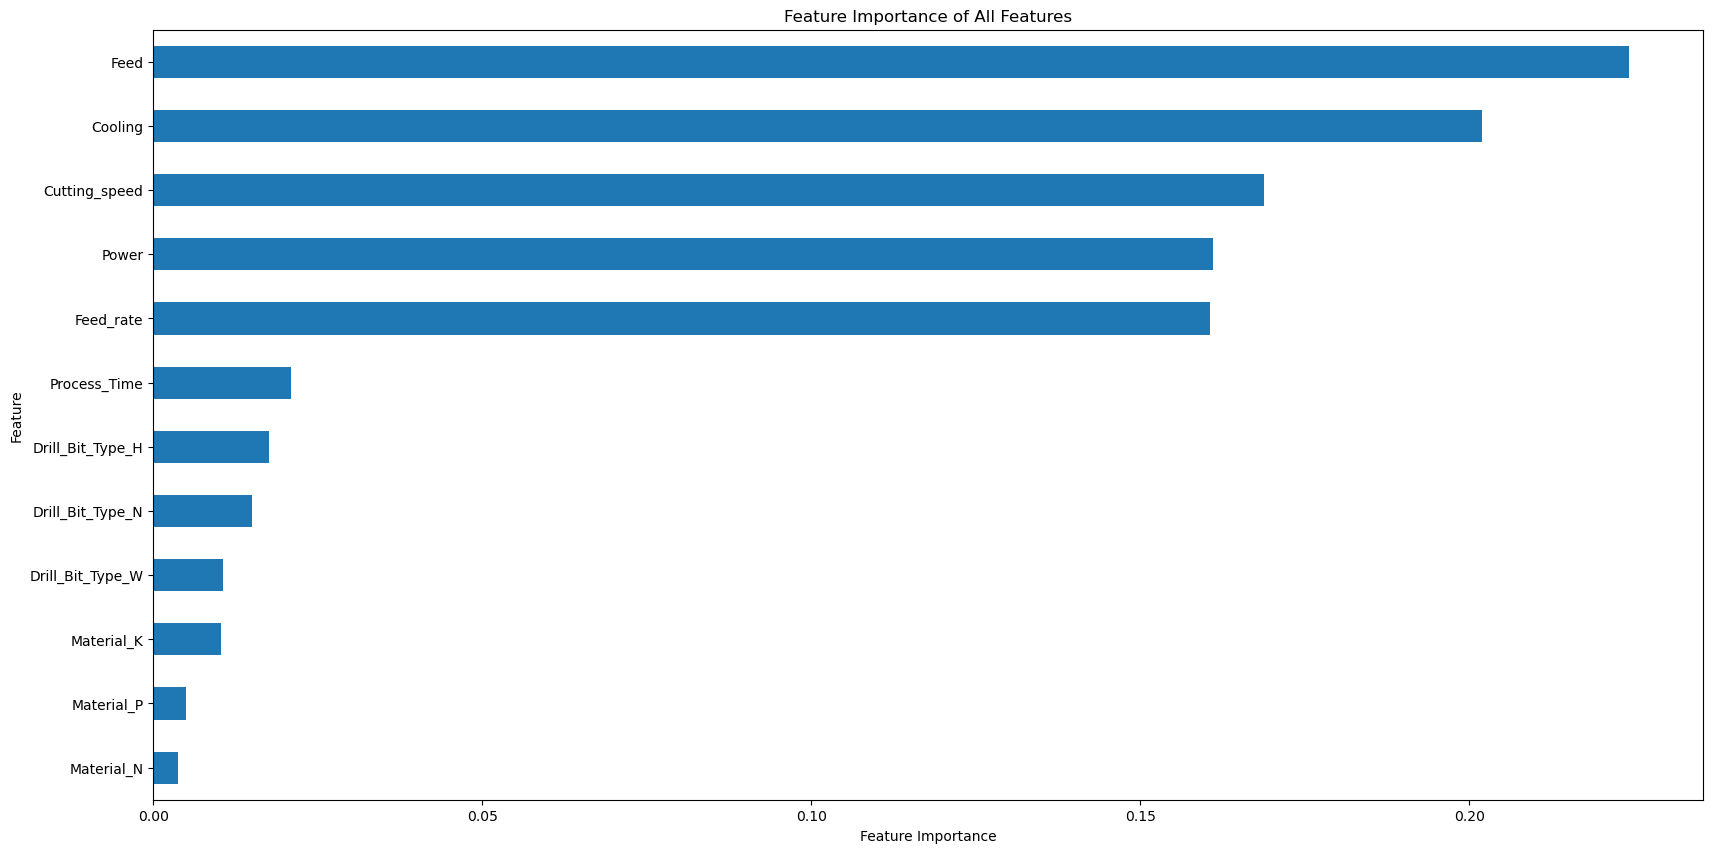

In [78]:
# Extract and sort feature importances
importances = pd.Series(rfmodel.feature_importances_, index=['Cutting_speed', 'Feed', 'Feed_rate', 'Power',
                                                           'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                                                           'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W'])
importances = importances.sort_values(ascending=True)

# Plot feature importances
importances.plot(kind='barh', figsize=(20, 10))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of All Features')
plt.grid(False)  # Disable grid lines
plt.show()

In [79]:
# List of feature names
feature_names = ['Cutting_speed', 'Feed', 'Feed_rate', 'Power',
                  'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                  'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W']

# Calculate permutation importance
perm_importance = permutation_importance(rfmodel, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for permutation importances
perm_feat_imp = pd.DataFrame({
    'feature': feature_names,
    'mean': perm_importance.importances_mean,
    'std': perm_importance.importances_std
})

# Sort by mean importance
perm_feat_imp.sort_values('mean', inplace=True, ascending=False)

# Display the top features
perm_feat_imp.head(14)

feature      mean       std
10  Drill_Bit_Type_N  0.323383  0.005996
11  Drill_Bit_Type_W  0.208500  0.004126
9   Drill_Bit_Type_H  0.198917  0.003253
2          Feed_rate  0.095883  0.001500
4            Cooling  0.090550  0.001696
0      Cutting_speed  0.039800  0.001719
1               Feed  0.012983  0.001139
3              Power  0.000817  0.000353
6         Material_K  0.000417  0.000134
8         Material_P  0.000183  0.000117
7         Material_N  0.000067  0.000082
5       Process_Time -0.000300  0.000194

### Hyperparameter Optimization Using Optuna

### Original dataset

In [80]:
# Optuna hyperparameters

def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 100)
    max_samples = trial.suggest_uniform('max_samples', 0.1, 1.0) if bootstrap else None
   
    # Use the existing model 
    rf = RandomForestClassifier(n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        criterion=criterion,
        class_weight=class_weight,
        max_leaf_nodes=max_leaf_nodes,
        max_samples=max_samples,
        random_state=42)
    
    # Perform cross-validation
    score = cross_val_score(rf, X_train, y_train, cv=5)
    accuracy = score.mean()
    
    return accuracy


In [81]:
# Set up the search
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-08-25 18:47:21,166] A new study created in memory with name: no-name-ac66c2a0-2f2b-4867-afe7-b9309480f8d4
[I 2024-08-25 18:47:57,642] Trial 0 finished with value: 0.9993571428571428 and parameters: {'n_estimators': 359, 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': False, 'criterion': 'entropy', 'class_weight': None, 'max_leaf_nodes': 76}. Best is trial 0 with value: 0.9993571428571428.
[I 2024-08-25 18:48:51,169] Trial 1 finished with value: 0.9979285714285714 and parameters: {'n_estimators': 374, 'max_depth': 8, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'gini', 'class_weight': None, 'max_leaf_nodes': 68}. Best is trial 0 with value: 0.9993571428571428.
[I 2024-08-25 18:49:01,916] Trial 2 finished with value: 0.9975714285714286 and parameters: {'n_estimators': 122, 'max_depth': 38, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstra

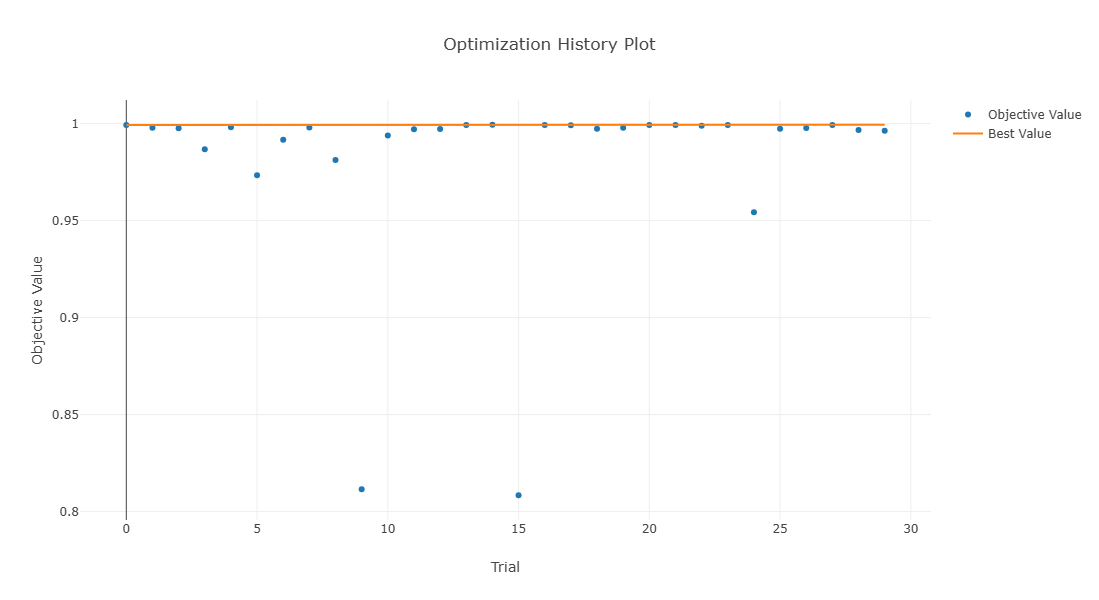

In [82]:
# Plot optimization history
opt_history = vis.plot_optimization_history(study)
opt_history.update_layout(width=1000, height=600)  # Set the size here
opt_history.show()

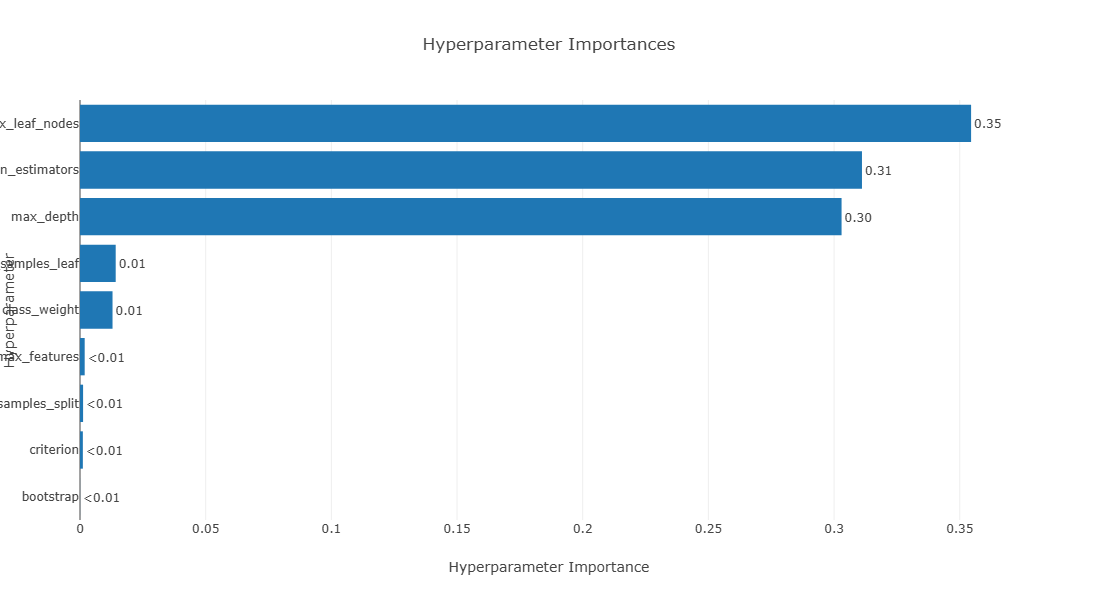

In [83]:
# Plot parameter importances
param_importances = vis.plot_param_importances(study)
param_importances.update_layout(width=1000, height=600)  # Set the size here
param_importances.show()

Gini on train = 100.0
Gini on test = 99.8


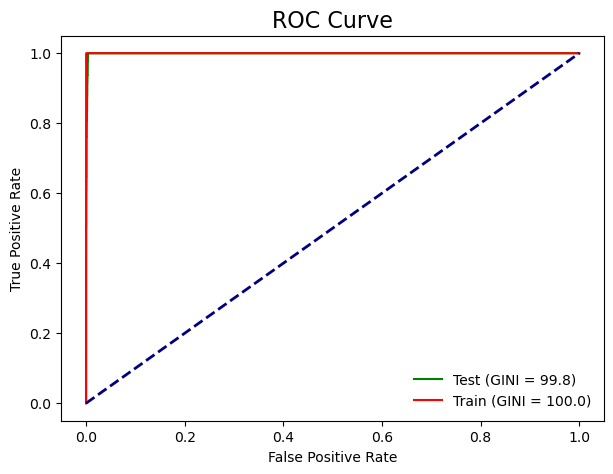

In [84]:
# Best hyperparameters
best_params = study.best_params

# best found parameters
best_model = RandomForestClassifier(**best_params)

# Train the model
best_model.fit(X_train, y_train)

# predict_proba on the trained model
train_gini, _, _ = gini(y_train, best_model.predict_proba(X_train)[:, 1], 'train')
test_gini, _, _ = gini(y_test, best_model.predict_proba(X_test)[:, 1], 'test')

# Plotting
plot_gini(y_train, best_model.predict_proba(X_train)[:, 1], y_test, best_model.predict_proba(X_test)[:, 1])


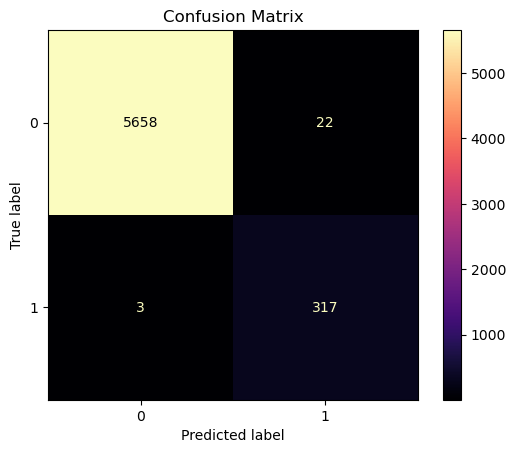

Test Classification Report:
                 precision    recall  f1-score   support

Machine Running       1.00      1.00      1.00      5680
 Machine Failed       0.94      0.99      0.96       320

       accuracy                           1.00      6000
      macro avg       0.97      0.99      0.98      6000
   weighted avg       1.00      1.00      1.00      6000



In [85]:
# Confusion matrix
pred = best_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
            y_test, pred,
            labels = best_model.classes_,
            cmap = 'magma')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print('Test Classification Report:')
print(classification_report(y_test, pred, target_names=['Machine Running', 'Machine Failed']))

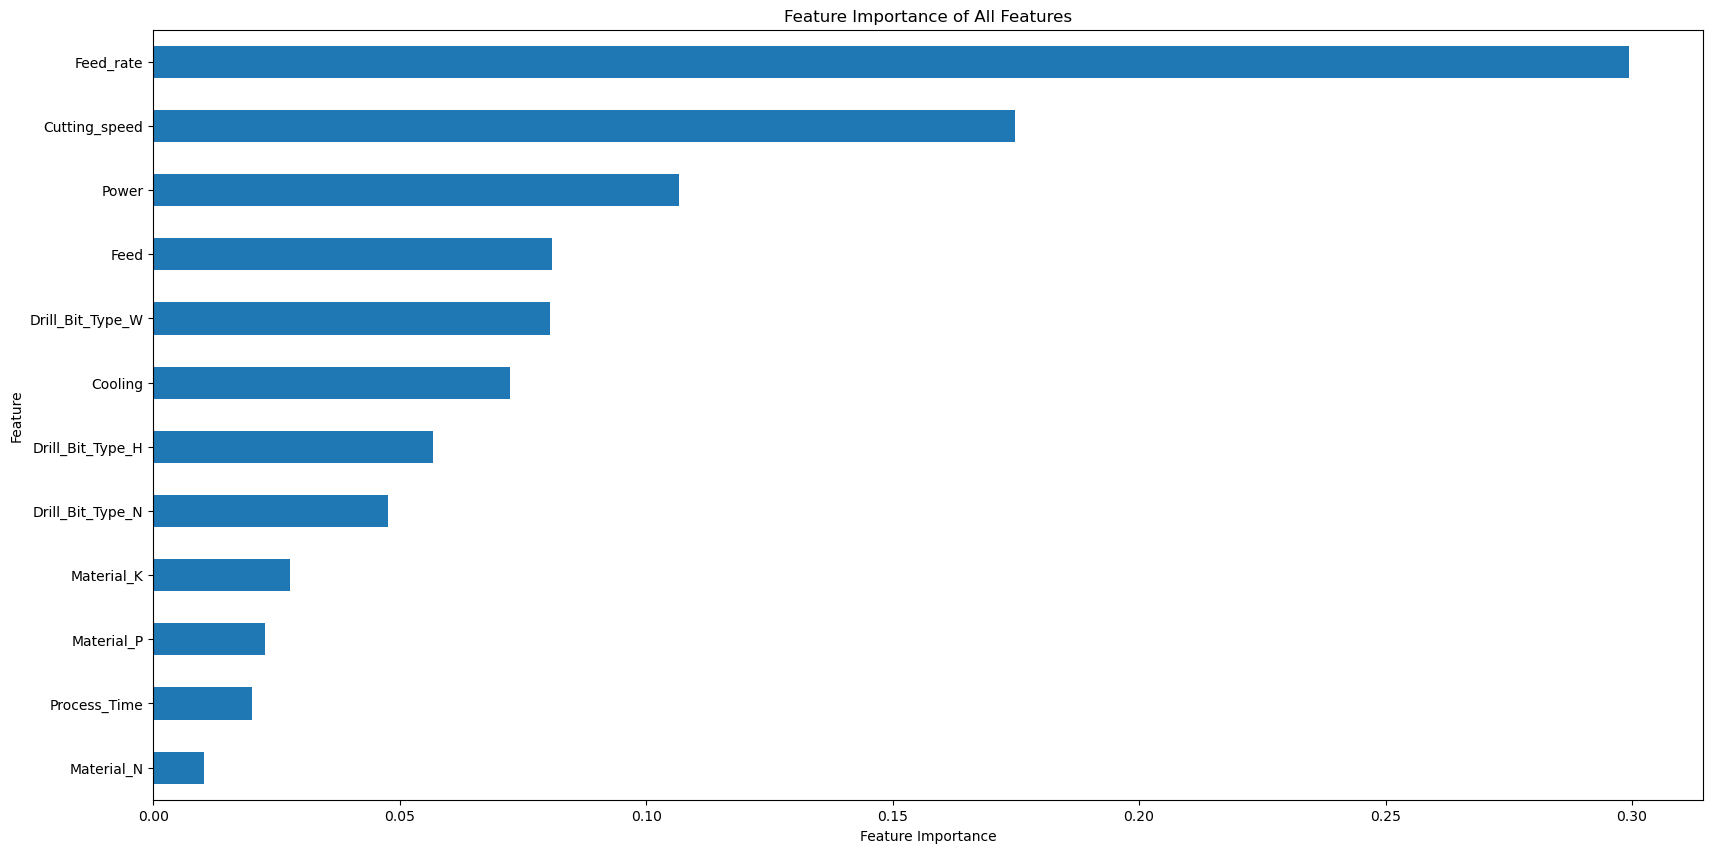

In [86]:
# Extract and sort feature importances
importances = pd.Series(best_model.feature_importances_, index=['Cutting_speed', 'Feed', 'Feed_rate', 'Power',
                                                           'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                                                           'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W'])
importances = importances.sort_values(ascending=True)

# Plot feature importances
importances.plot(kind='barh', figsize=(20, 10))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of All Features')
plt.grid(False)  # Disable grid lines
plt.show()

In [87]:
# List of feature names
feature_names = ['Cutting_speed', 'Feed', 'Feed_rate', 'Power',
                  'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                  'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W']

# Calculate permutation importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for permutation importances
perm_feat_imp = pd.DataFrame({
    'feature': feature_names,
    'mean': perm_importance.importances_mean,
    'std': perm_importance.importances_std
})

# Sort by mean importance
perm_feat_imp.sort_values('mean', inplace=True, ascending=False)

# Display the top features
perm_feat_imp.head(14)

feature      mean       std
9   Drill_Bit_Type_H  0.325667  0.005191
11  Drill_Bit_Type_W  0.250883  0.005277
10  Drill_Bit_Type_N  0.138067  0.002983
2          Feed_rate  0.113333  0.001759
4            Cooling  0.056400  0.002479
0      Cutting_speed  0.039217  0.001630
1               Feed  0.000300  0.000100
3              Power  0.000233  0.000200
5       Process_Time  0.000167  0.000000
6         Material_K  0.000000  0.000000
7         Material_N  0.000000  0.000000
8         Material_P  0.000000  0.000000

### Balanced data

In [88]:
# Optuna hyperparameters

def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 100)
    max_samples = trial.suggest_uniform('max_samples', 0.1, 1.0) if bootstrap else None
   
    # Use the existing model 
    rf = RandomForestClassifier(n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        criterion=criterion,
        class_weight=class_weight,
        max_leaf_nodes=max_leaf_nodes,
        max_samples=max_samples,
        random_state=42)
    
    # Perform cross-validation
    score = cross_val_score(rf, X_resampled_b, y_resampled_b, cv=5)
    accuracy = score.mean()
    
    return accuracy

In [89]:
# Set up the search
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-08-25 19:05:19,254] A new study created in memory with name: no-name-3a7af745-4f6c-49ef-ad4a-c76abffa193a
[I 2024-08-25 19:05:49,541] Trial 0 finished with value: 0.9798047272915866 and parameters: {'n_estimators': 82, 'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced', 'max_leaf_nodes': 94}. Best is trial 0 with value: 0.9798047272915866.
[I 2024-08-25 19:06:06,542] Trial 1 finished with value: 0.968242172151502 and parameters: {'n_estimators': 97, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 16, 'max_features': 'auto', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_leaf_nodes': 60, 'max_samples': 0.9171625884432151}. Best is trial 0 with value: 0.9798047272915866.
[I 2024-08-25 19:06:24,620] Trial 2 finished with value: 0.9798047272915866 and parameters: {'n_estimators': 60, 'max_depth': 23, 'min_samples_split': 2, 'min_samples

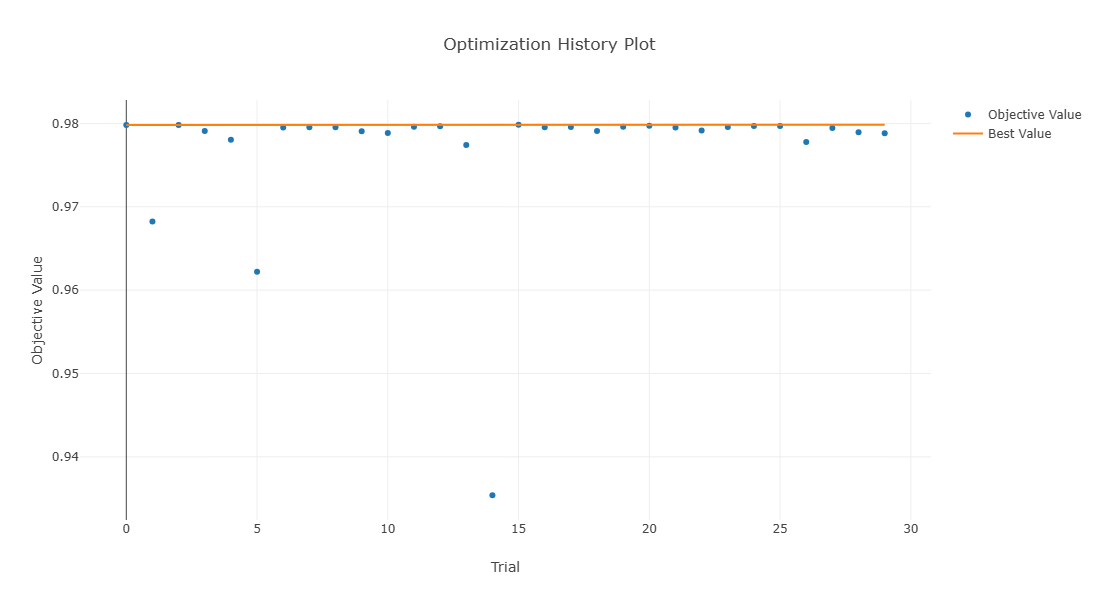

In [90]:
# Plot optimization history
opt_history = vis.plot_optimization_history(study)
opt_history.update_layout(width=1000, height=600)  # Set the size here
opt_history.show()

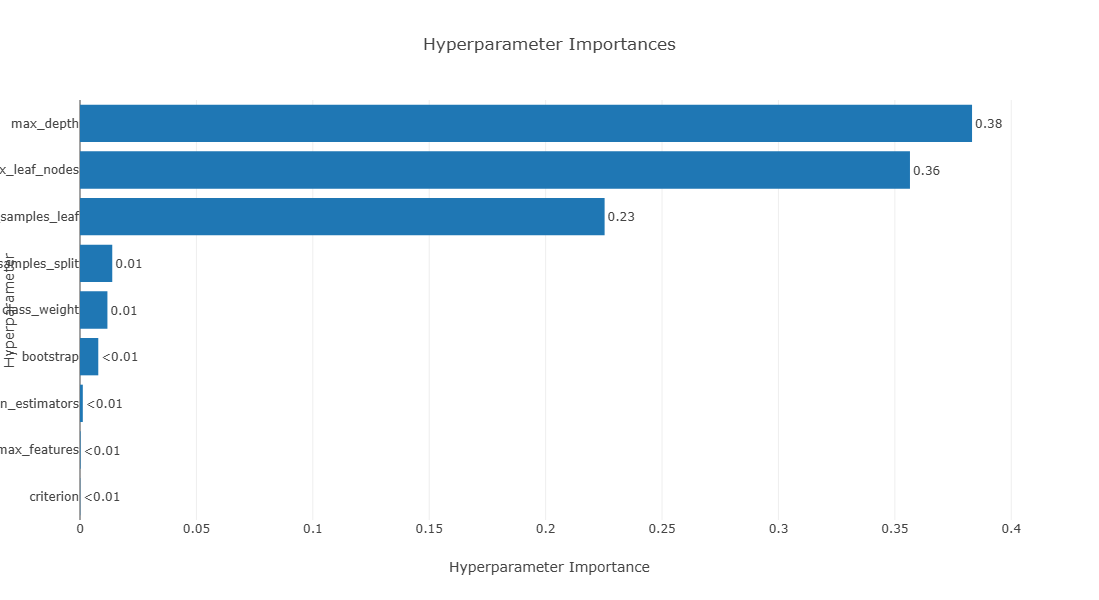

In [91]:
# Plot parameter importances
param_importances = vis.plot_param_importances(study)
param_importances.update_layout(width=1000, height=600)  # Set the size here
param_importances.show()

Gini on train = 100.0
Gini on test = 99.3


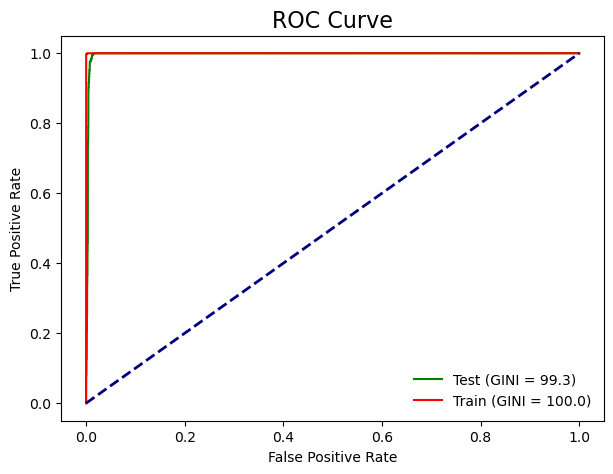

In [92]:
# Best hyperparameters
best_params = study.best_params

# best found parameters
best_model = RandomForestClassifier(**best_params)

# Train the model
best_model.fit(X_resampled_b, y_resampled_b)

# predict_proba on the trained model
train_gini, _, _ = gini(y_resampled_b, best_model.predict_proba(X_resampled_b)[:, 1], 'train')
test_gini, _, _ = gini(y_test, best_model.predict_proba(X_test)[:, 1], 'test')

# Plotting 
plot_gini(y_resampled_b, best_model.predict_proba(X_resampled_b)[:, 1], y_test, best_model.predict_proba(X_test)[:, 1])


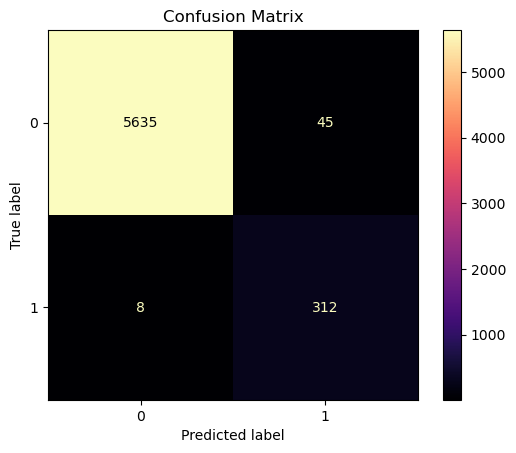

Test Classification Report:
                 precision    recall  f1-score   support

Machine Running       1.00      0.99      1.00      5680
 Machine Failed       0.87      0.97      0.92       320

       accuracy                           0.99      6000
      macro avg       0.94      0.98      0.96      6000
   weighted avg       0.99      0.99      0.99      6000



In [93]:
pred = best_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
            y_test, pred,
            labels = best_model.classes_,
            cmap = 'magma')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print('Test Classification Report:')
print(classification_report(y_test, pred, target_names=['Machine Running', 'Machine Failed']))

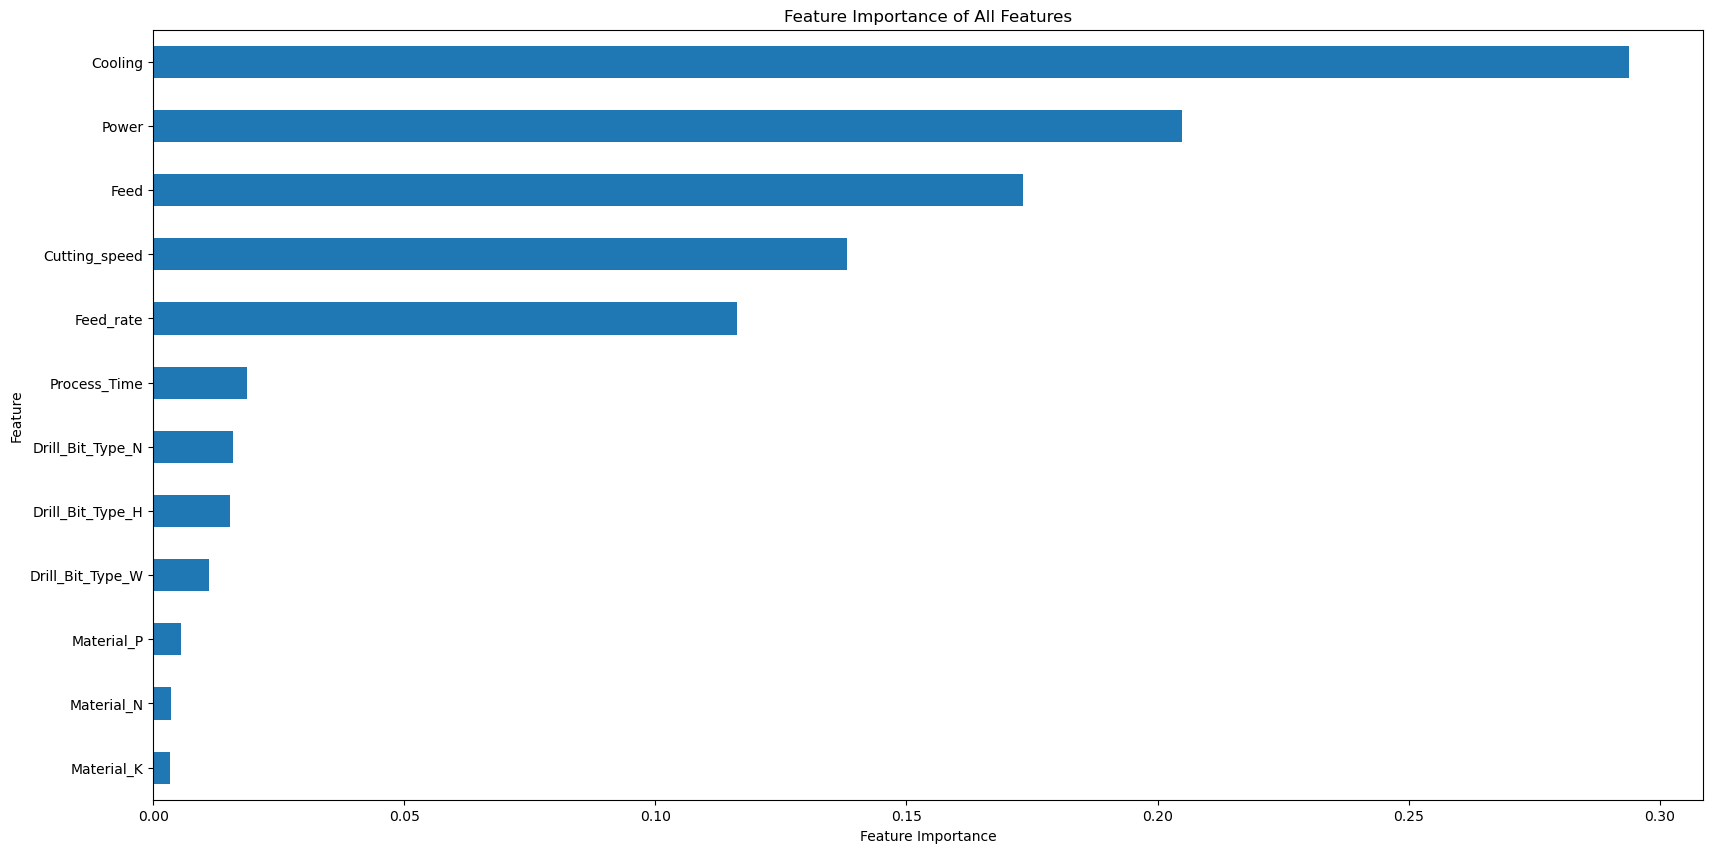

In [94]:
# Extract and sort feature importances
importances = pd.Series(best_model.feature_importances_, index=['Cutting_speed', 'Feed', 'Feed_rate', 'Power',
                                                           'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                                                           'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W'])
importances = importances.sort_values(ascending=True)

# Plot feature importances
importances.plot(kind='barh', figsize=(20, 10))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of All Features')
plt.grid(False)  # Disable grid lines
plt.show()

In [95]:
# List of feature names
feature_names = ['Cutting_speed', 'Feed', 'Feed_rate', 'Power',
                  'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                  'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W']

# Calculate permutation importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for permutation importances
perm_feat_imp = pd.DataFrame({
    'feature': feature_names,
    'mean': perm_importance.importances_mean,
    'std': perm_importance.importances_std
})

# Sort by mean importance
perm_feat_imp.sort_values('mean', inplace=True, ascending=False)

# Display the top features
perm_feat_imp.head(14)

feature      mean       std
10  Drill_Bit_Type_N  0.130100  0.003292
11  Drill_Bit_Type_W  0.129300  0.002196
2          Feed_rate  0.096367  0.001891
9   Drill_Bit_Type_H  0.064767  0.001465
0      Cutting_speed  0.029317  0.002212
4            Cooling  0.011133  0.001092
1               Feed  0.002100  0.000850
8         Material_P  0.001067  0.000260
5       Process_Time  0.000817  0.000353
6         Material_K  0.000650  0.000189
7         Material_N  0.000517  0.000174
3              Power  0.000167  0.000459

In [96]:
#import pickle
#file = open('PM_random_forest_model.pkl','wb')
#pickle.dump(best_model, file)
#file.close()